# Standard Includes

In [0]:
import torch 
import torchvision
import torch.nn as nn
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import copy

from __future__ import print_function
from sklearn.utils import shuffle
import os
import random
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.utils as vutils

# Set Random Seed

In [0]:
manual_seed = 1000

In [5]:
if manual_seed is None:
    manual_seed = random.randint(1, 10000)
print("Random Seed: ", manual_seed)
random.seed(manual_seed)
torch.manual_seed(manual_seed)

Random Seed:  1000


# Login to Drive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Datasets

## 2D Uniform Gaussian

In [0]:
class Gaussian2D(torch.utils.data.Dataset):
    def __init__(self, mean, size):
        m = [mean, mean]
        cov = [[1, 0], [0, 1]]

        # Load Data 
        self.x_train = np.random.multivariate_normal(m, cov, size)
        
        self.y_train = np.ones((size, 1))

    def __getitem__(self, index):
        return (self.x_train[index], self.y_train[index])

    def __len__(self):
        return self.x_train.shape[0]

## 2D Mixture of Gaussians

In [0]:
class MixGaussian2D(torch.utils.data.Dataset):
    # mix_num : number of mixtures
    # meeans : 2d array of means
    def __init__(self, mix_num, means, size_per_mix, cov_factor=1, labels = 0):
      self.x_train = np.zeros((sum(size_per_mix), 2))
      self.y_train = np.zeros((sum(size_per_mix)))

      # Keep track of index
      idx = 0
      for i in range(mix_num):
        m = [means[i][0], means[i][1]]
        cov = [[cov_factor, 0], [0, cov_factor]]

        # Load Data 
        self.x_train[idx: idx + size_per_mix[i]] = np.random.multivariate_normal(m, cov, size_per_mix[i])
        self.y_train[idx: idx + size_per_mix[i]] = i*np.ones((size_per_mix[i], ))

        # Update index
        idx = idx + size_per_mix[i]
      
      # Shuffle data
      self.x_train, self.y_train = shuffle(self.x_train, self.y_train)

      if not labels:
        self.y_train = np.ones((sum(size_per_mix)))
        
    def __getitem__(self, index):
      return (self.x_train[index], self.y_train[index])

    def __len__(self):
      return self.x_train.shape[0]


# GAN Setup

## Hyper parameter setup

In [1]:
hyperparam = {
  # Device configuration
  "device" : torch.device('cuda' if torch.cuda.is_available() else 'cpu'),

  "latent_size" : 8,
  "hidden_size" : 32,
  "data_dim" : 2,
  "num_epochs" : 10000,
  "batch_size" : 100,
  "lr" : 0.0002,

  # Averaging schedule (ony one of epoch_avg and baatch_avg can be true)
  "epoch_avg" : True,
  "epoch_stride" : 1
  "batch_avg" : False,
  "batch_stride" : 1

  # When plotting, smaplee theese many points from the current model
  "plot_batch_size" : 100,
  "plot_epoch" : 100
}

SyntaxError: ignored

## Architecture

In [0]:
# Discriminator
D = nn.Sequential(
    nn.Linear(hyperparam["data_dim"], hyperparam["hidden_size"]),
    nn.LeakyReLU(0.2),
    nn.Linear(hyperparam["hidden_size"], hyperparam["hidden_size"]),
    nn.LeakyReLU(0.2),
    nn.Linear(hyperparam["hidden_size"], 1),
    nn.Sigmoid())

# Generator 
G = nn.Sequential(
    nn.Linear(hyperparam["latent_size"], hyperparam["hidden_size"]),
    nn.ReLU(),
    nn.Linear(hyperparam["hidden_size"], hyperparam["hidden_size"]),
    nn.ReLU(),
    nn.Linear(hyperparam["hidden_size"], hyperparam["data_dim"]),
    nn.Tanh())

# Device setting
D = D.to(hyperparam["device"])
G = G.to(hyperparam["device"])

## Loss and Optimization

In [0]:
opt = {
  # Binary cross entropy loss
  "criterion" : nn.BCELoss(),
  "d_optimizer" : torch.optim.Adam(D.parameters(), lr=hyperparam["lr"]),
  "g_optimizer" : torch.optim.Adam(G.parameters(), lr=hyperparam["lr"])
}

# Helper function
def reset_grad(opt):
    opt["d_optimizer"].zero_grad()
    opt["g_optimizer"].zero_grad()

In [0]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=hyperparam["lr"])
g_optimizer = torch.optim.Adam(G.parameters(), lr=hyperparam["lr"])

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

# Training

In [0]:
def train_gan(ds, D, G, hyperparam, opt):  
    data_loader = torch.utils.data.DataLoader(dataset=ds,
                                           batch_size=hyperparam["batch_size"], 
                                           shuffle=True)
    
    g_loss_list = []
    e = [] # epoch list
    d_loss_real_list = []
    d_loss_fake_list = []
    total_step = len(data_loader)

    moving_avg = G.state_dict()
    G_copy = copy.deepcopy(G)
    for epoch in range(hyperparam["num_epochs"]):
        e.append(epoch)
        for i, (data_point, _) in enumerate(data_loader):
            #data_point = data_point.reshape(hyperparam["batch_size"], -1).to(hyperparam["device"])
            data_point = data_point.to(hyperparam["device"])
            # Create the labels which are later used as input for the BCE loss
            real_labels = torch.ones(hyperparam["batch_size"], 1).to(hyperparam["device"])
            fake_labels = torch.zeros(hyperparam["batch_size"], 1).to(hyperparam["device"])

            # ================================================================== #
            #                      Train the discriminator                       #
            # ================================================================== #

            # Compute BCE_Loss using real images where BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
            # Second term of the loss is always zero since real_labels == 1
            outputs = D(data_point.float())
            
            d_loss_real = opt["criterion"](outputs, real_labels)
            if i == total_step - 1:
                d_loss_real_list.append(d_loss_real)
            real_score = outputs
            
            # Compute BCELoss using fake images
            # First term of the loss is always zero since fake_labels == 0
            z = torch.randn(hyperparam["batch_size"], hyperparam["latent_size"]).to(hyperparam["device"])
            fake_images = G(z)
            outputs = D(fake_images)
            d_loss_fake = opt["criterion"](outputs, fake_labels)
            if i == total_step - 1:
                d_loss_fake_list.append(d_loss_fake)
            fake_score = outputs
            
            # Backprop and optimize
            d_loss = d_loss_real + d_loss_fake
            reset_grad(opt)
            d_loss.backward()
            opt["d_optimizer"].step()
            
            # ================================================================== #
            #                        Train the generator                         #
            # ================================================================== #

            # Compute loss with fake images
            z = torch.randn(hyperparam["batch_size"], hyperparam["latent_size"]).to(hyperparam["device"])

            fake_images = G(z)
            outputs = D(fake_images)
            
            # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
            # For the reason, see the last paragraph of section 3. https://arxiv.org/pdf/1406.2661.pdf
            g_loss = opt["criterion"](outputs, real_labels)
            if i == total_step - 1:
                g_loss_list.append(g_loss)

            # Backprop and optimize
            reset_grad(opt)
            g_loss.backward()
            opt["g_optimizer"].step()
            
            if (i+1) % 200 == 0:
                print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                      .format(epoch, hyperparam["num_epochs"], i+1, total_step, d_loss.item(), g_loss.item(), 
                              real_score.mean().item(), fake_score.mean().item()))
        
        
            # Print State of the GAN
            '''if epoch % 10000 == 0:
                print("The current data point is {}".format(data_point))
                print("The current prediction is {}".format(fake_images))'''

            if not hyperparam["epoch_avg"] and hyperparam["batch_avg"] and (i + 1) % hyperparam["batch_step"] == 0:
                g_dict = G.state_dict()

                for param, weights in moving_avg.items():
                    if param in g_dict:
                        moving_avg[param].data.copy_(((epoch)/(epoch + 1))* weights.data + (1/(epoch + 1))* g_dict[param].data)

        if not hyperparam["batch_avg"] and hyperparam["epoch_avg"] and (epoch + 1) % hyperparam["epoch_step"] == 0:
            g_dict = G.state_dict()

            for param, weights in moving_avg.items():
                if param in g_dict:
                    moving_avg[param].data.copy_(((epoch)/(epoch + 1))* weights.data + (1/(epoch + 1))* g_dict[param].data)

          #print(m["0.weight"].shape)
        #for param in G.parameters():
        #  print(param.data)

        if epoch % hyperparam["plot_epoch"] == 0:
            print("\n Epoch : {}".format(epoch))
            plt.plot(e, d_loss_real_list, 'b-', label = 'd_loss_real')
            plt.plot(e, d_loss_fake_list, 'g-', label = 'd_loss_fake') 
            plt.plot(e, g_loss_list, 'r-', label = 'g_loss')
            plt.legend()
            plt.show()

            # Sample from real data
            ds_shape = ds[:][0].shape
            ds_sample_idx = np.random.choice(ds_shape[0], hyperparam["plot_batch_size"], replace=False)
            ds_sample = ds[:][0][ds_sample_idx]

            # Sample from current model
            z_plot = torch.randn(hyperparam["plot_batch_size"], hyperparam["latent_size"]).to(hyperparam["device"])
            output_plot = G(z_plot)
                          
            plt.plot(ds_sample[:, 0], ds_sample[:, 1], 'bo', label = 'Real Data')
            plt.plot(output_plot[:, 0].cpu().detach().numpy(), output_plot[:, 1].cpu().detach().numpy(), 'ro', label = 'Fake Data')
            plt.title("With Current Model")
            plt.legend()
            plt.show()

            # Sample from average model
            z_plot = torch.randn(hyperparam["plot_batch_size"], hyperparam["latent_size"]).to(hyperparam["device"])
            G_copy.load_state_dict(moving_avg)
            output_plot = G_copy(z_plot)

            plt.plot(ds_sample[:, 0], ds_sample[:, 1], 'bo', label = 'Real Data')
            plt.plot(output_plot[:, 0].cpu().detach().numpy(), output_plot[:, 1].cpu().detach().numpy(), 'ro', label = 'Fake Data')
            plt.title("With Averaged Model")
            plt.legend()
            plt.show()


 Epoch : 0


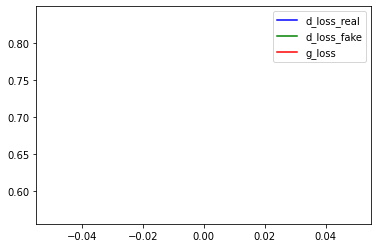

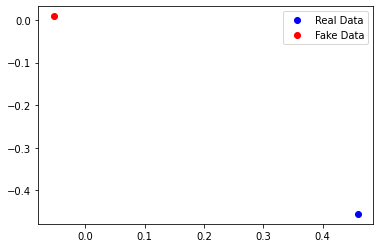


 Epoch : 1000


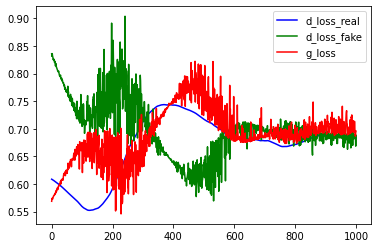

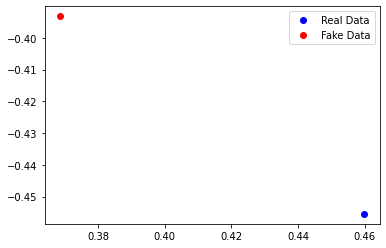


 Epoch : 2000


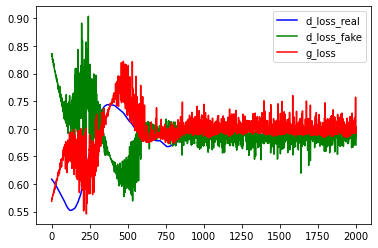

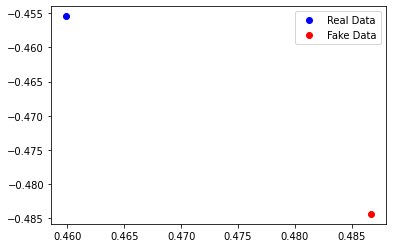


 Epoch : 3000


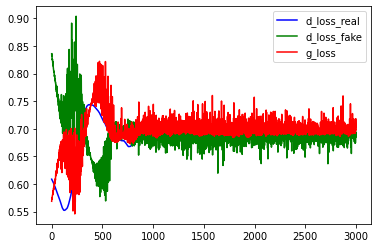

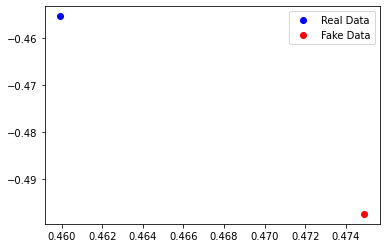


 Epoch : 4000


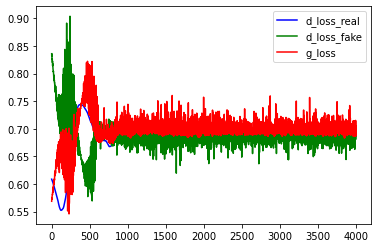

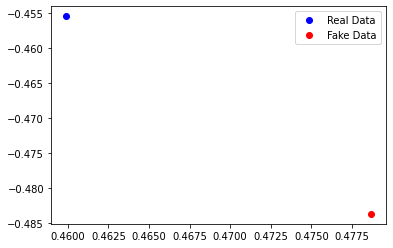


 Epoch : 5000


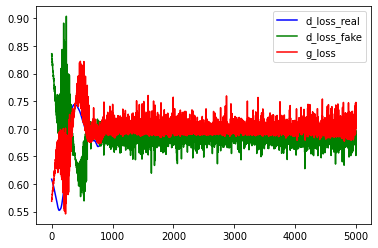

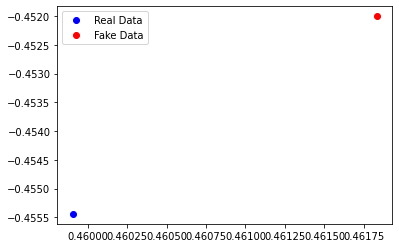


 Epoch : 6000


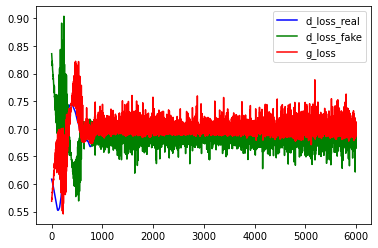

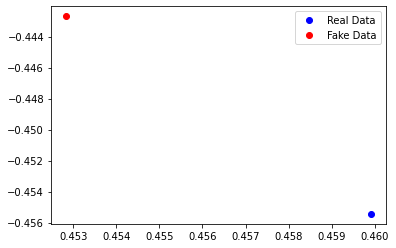


 Epoch : 7000


KeyboardInterrupt: ignored

In [131]:
ds = MixGaussian2D(1, [[0.5,-0.5]], [1], cov_factor = 0.01)
train_gan(ds, D, G, hyperparam, opt)


 Epoch : 0


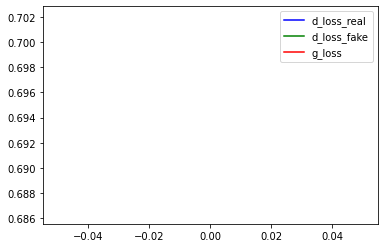

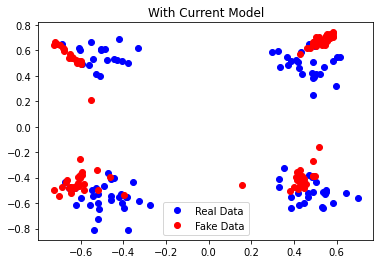

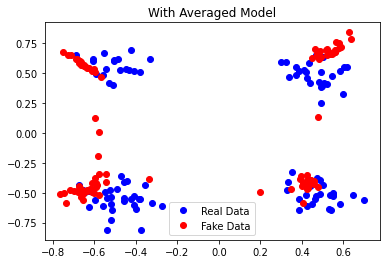


 Epoch : 100


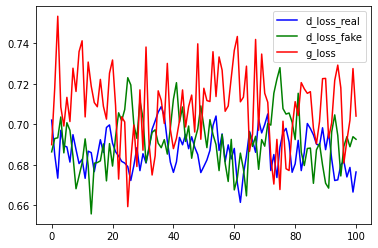

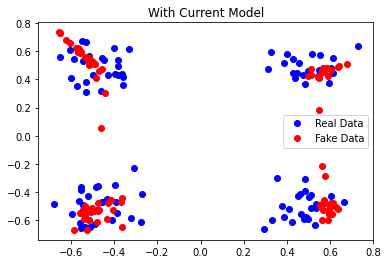

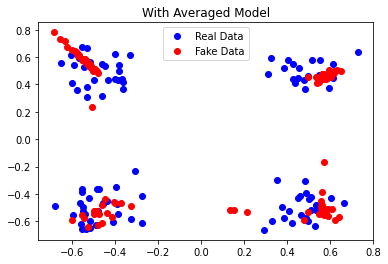


 Epoch : 200


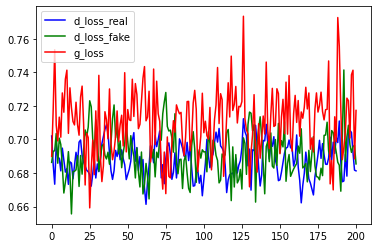

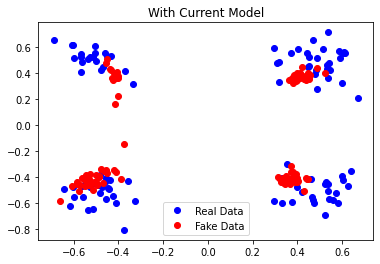

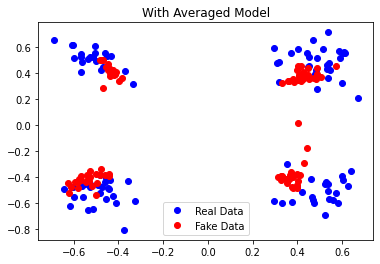


 Epoch : 300


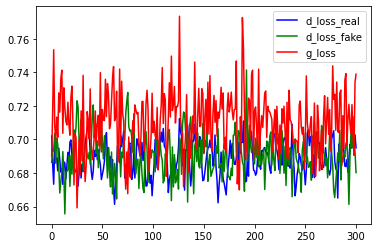

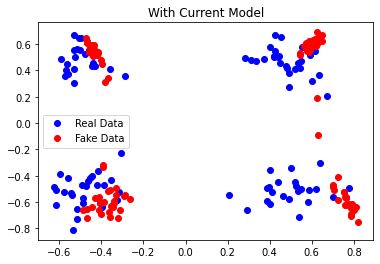

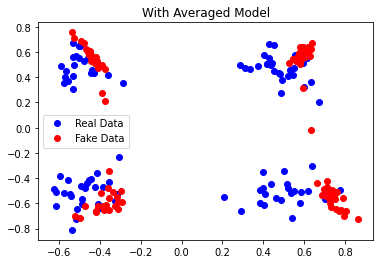


 Epoch : 400


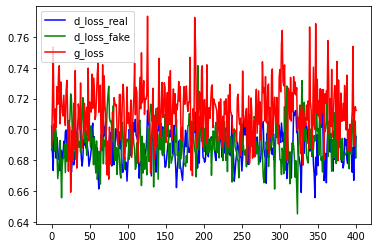

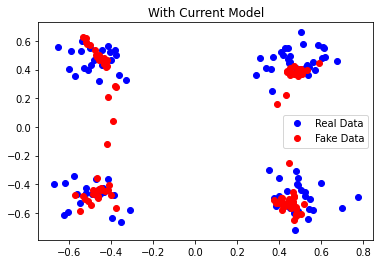

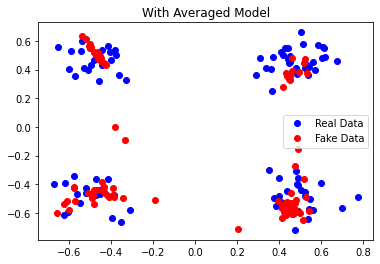


 Epoch : 500


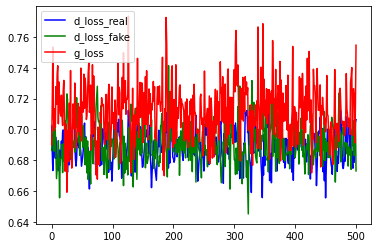

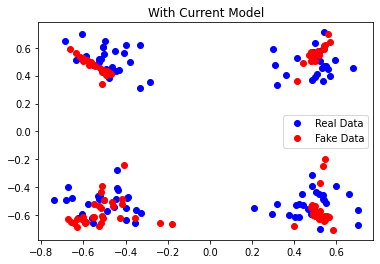

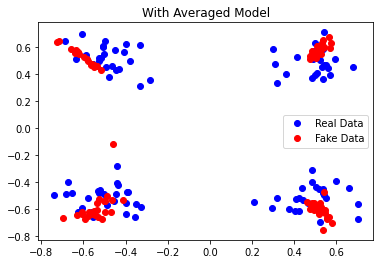


 Epoch : 600


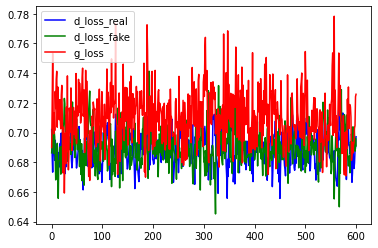

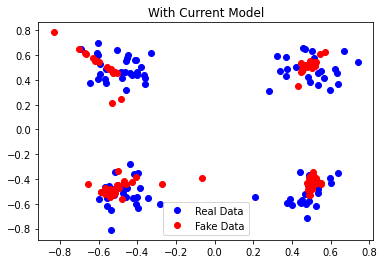

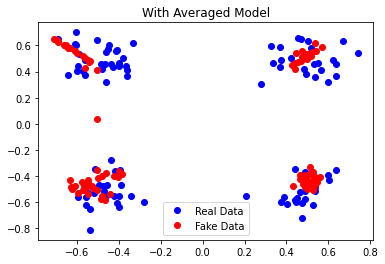


 Epoch : 700


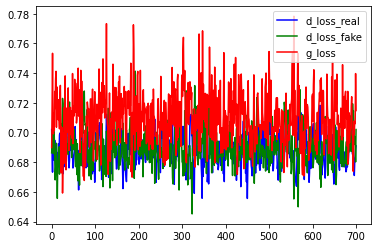

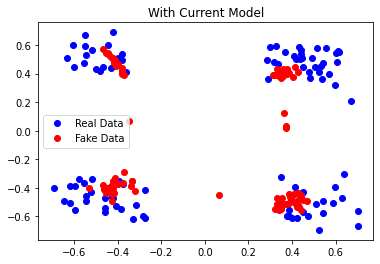

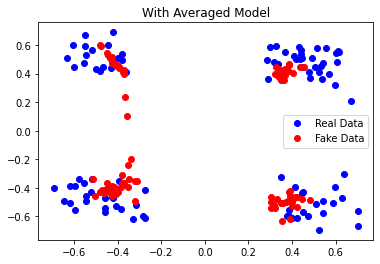


 Epoch : 800


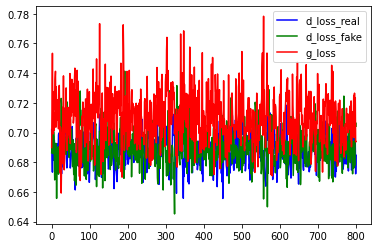

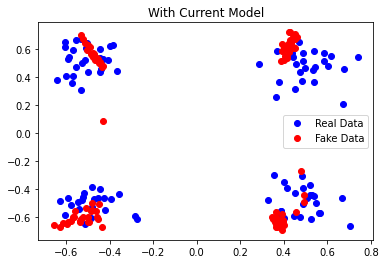

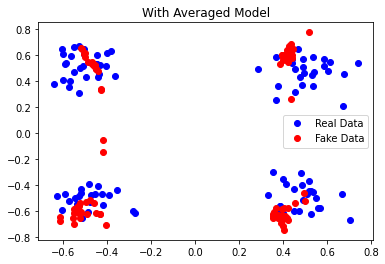


 Epoch : 900


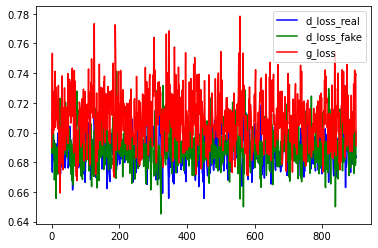

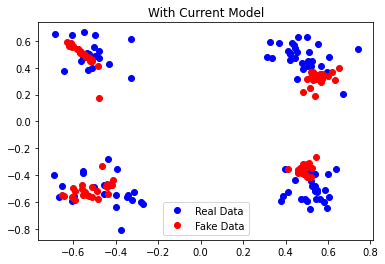

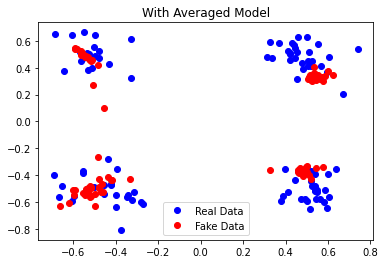


 Epoch : 1000


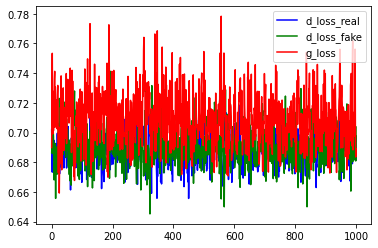

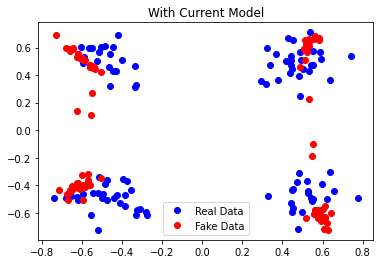

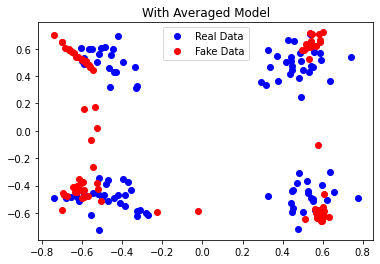


 Epoch : 1100


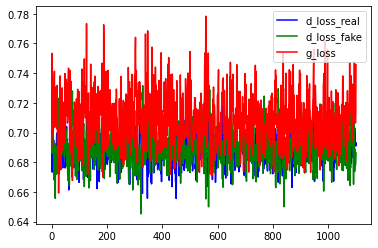

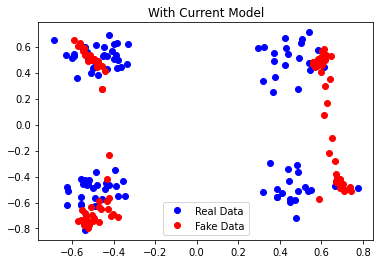

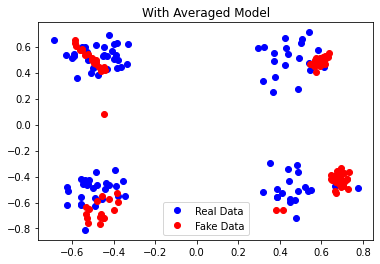


 Epoch : 1200


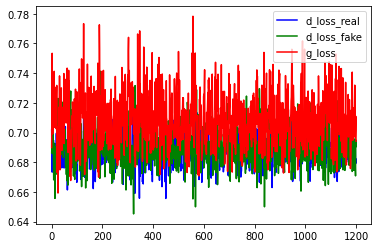

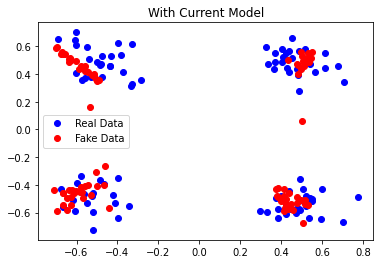

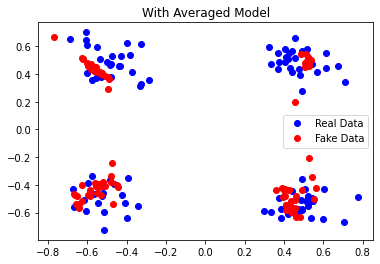


 Epoch : 1300


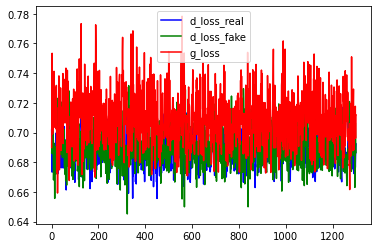

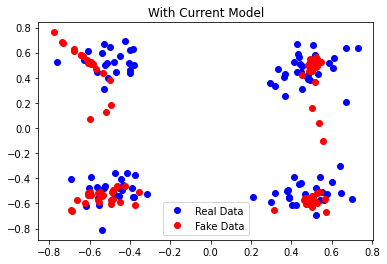

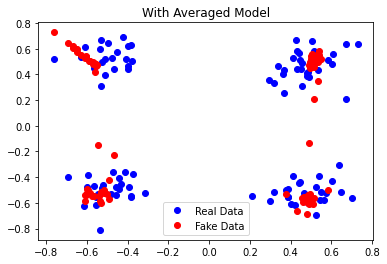


 Epoch : 1400


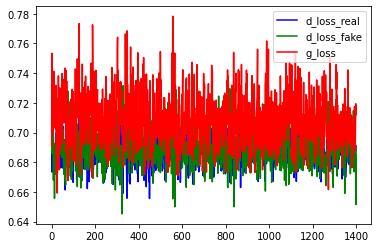

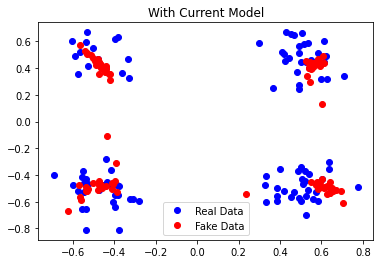

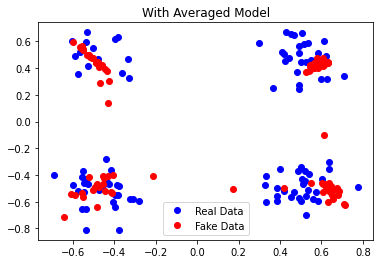


 Epoch : 1500


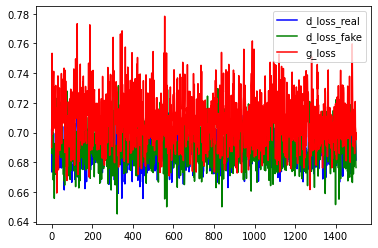

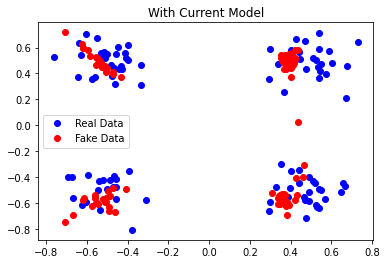

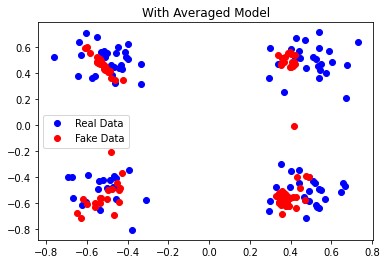


 Epoch : 1600


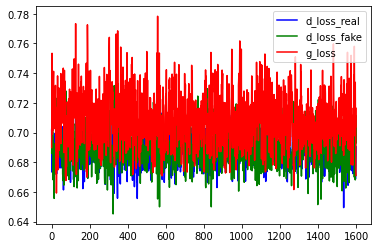

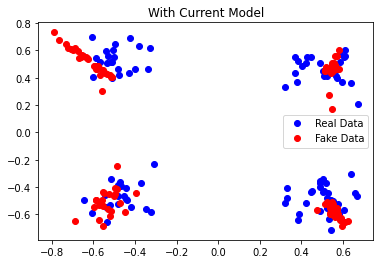

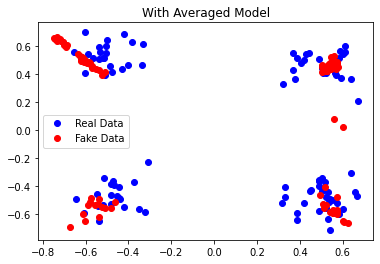


 Epoch : 1700


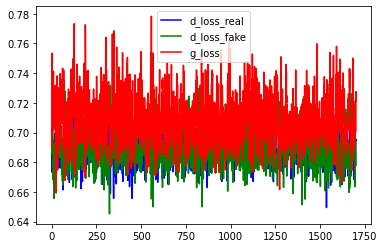

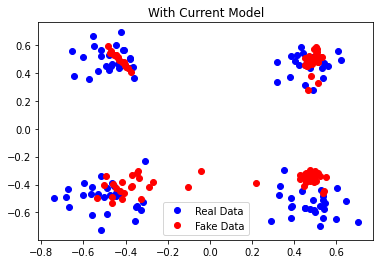

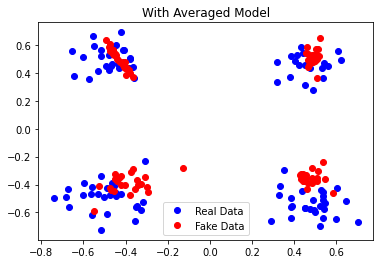


 Epoch : 1800


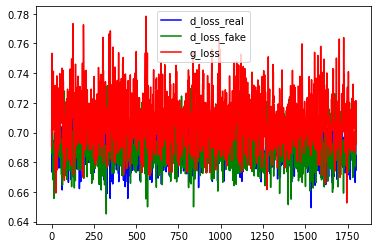

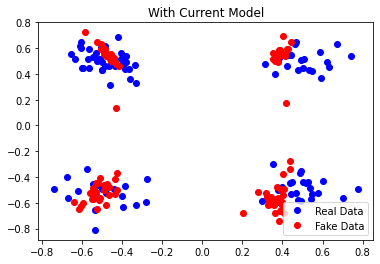

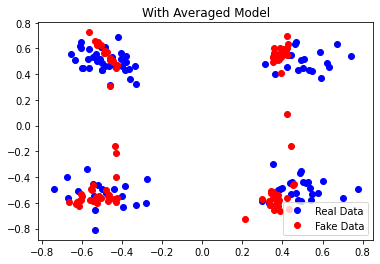


 Epoch : 1900


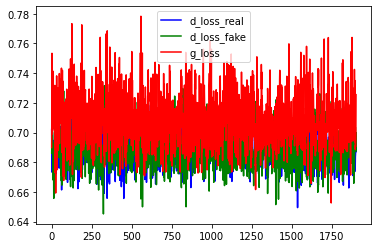

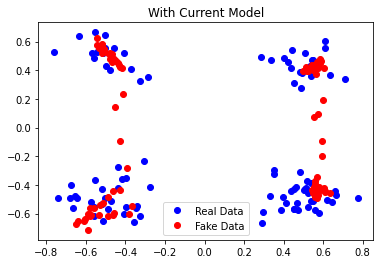

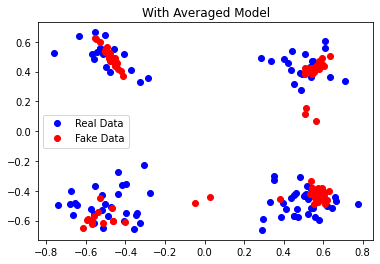


 Epoch : 2000


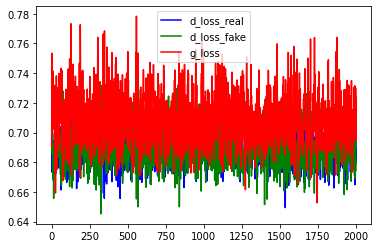

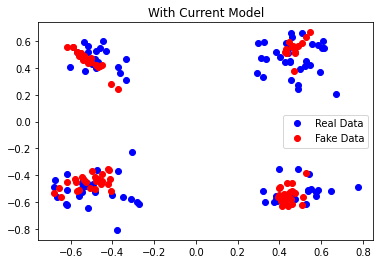

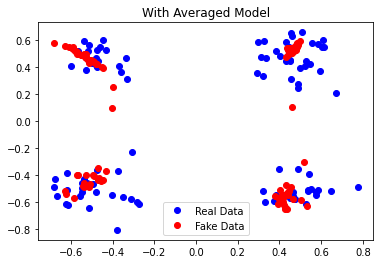


 Epoch : 2100


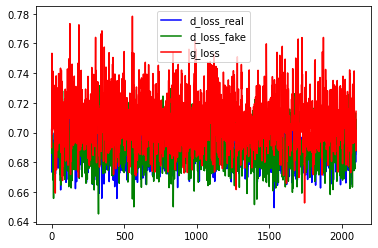

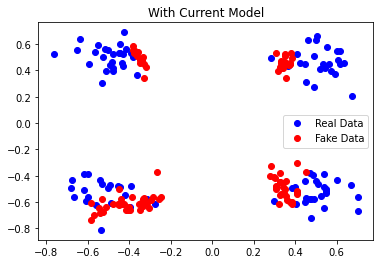

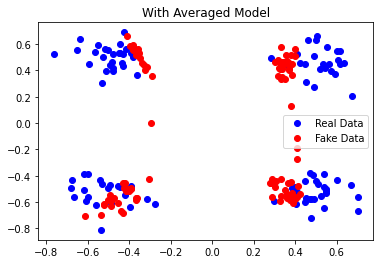


 Epoch : 2200


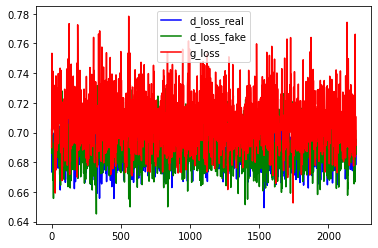

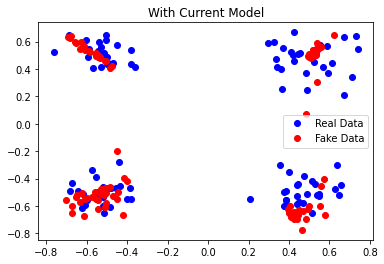

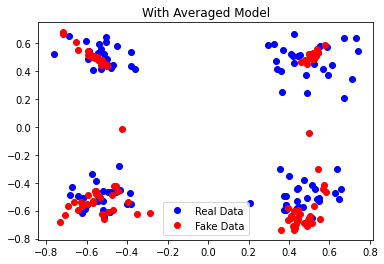


 Epoch : 2300


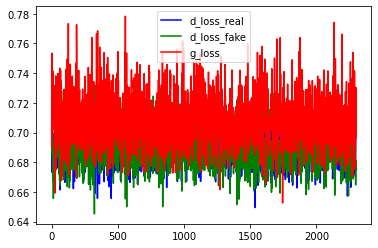

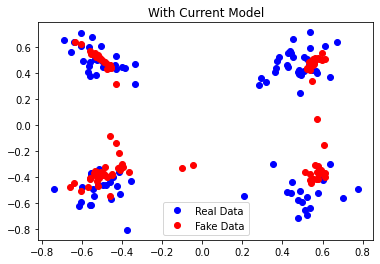

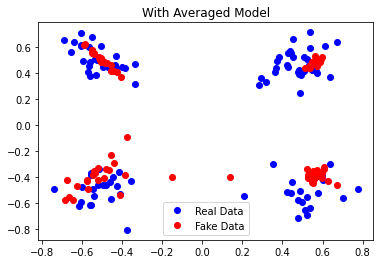


 Epoch : 2400


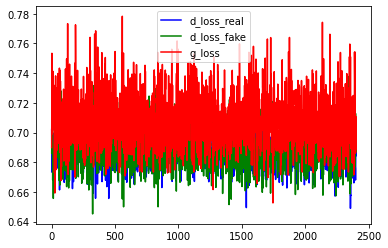

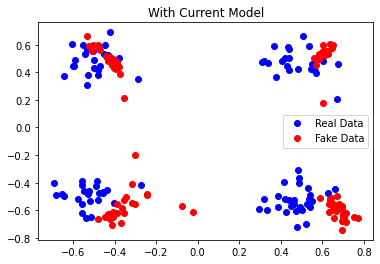

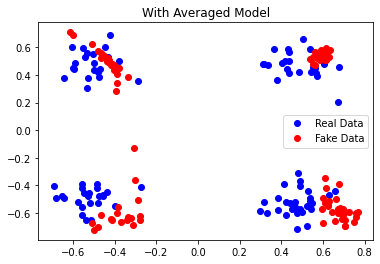


 Epoch : 2500


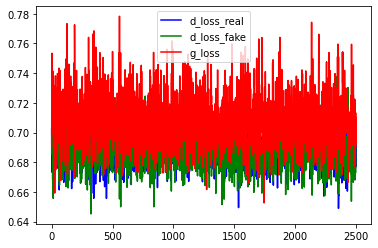

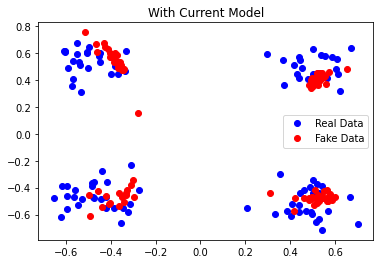

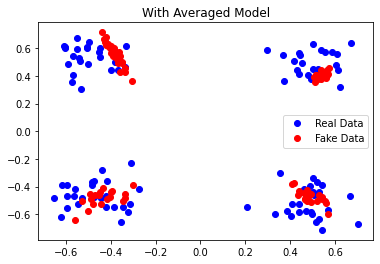


 Epoch : 2600


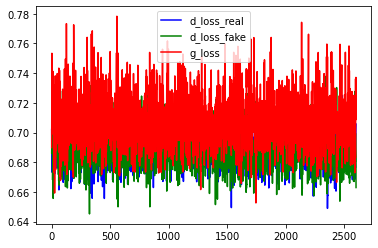

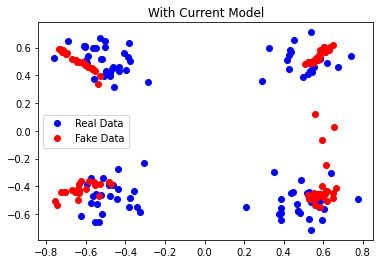

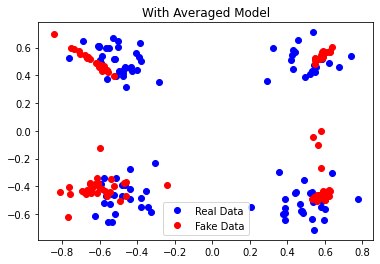


 Epoch : 2700


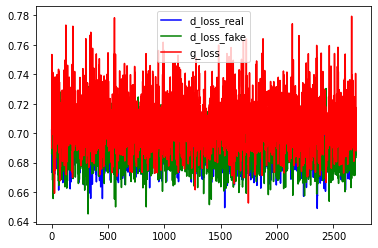

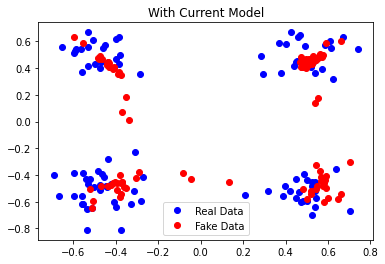

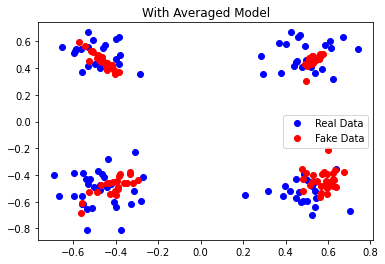


 Epoch : 2800


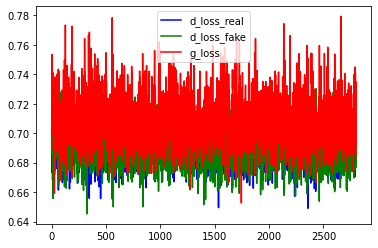

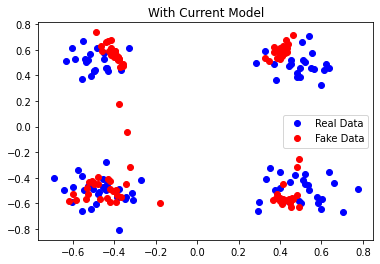

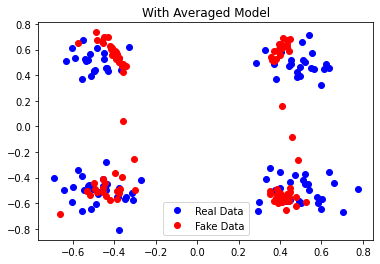


 Epoch : 2900


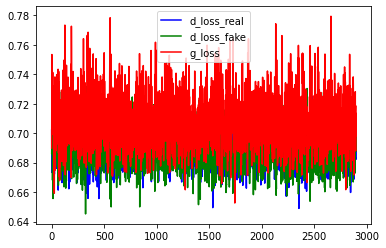

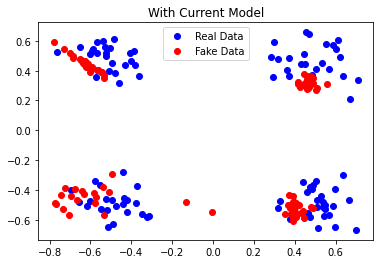

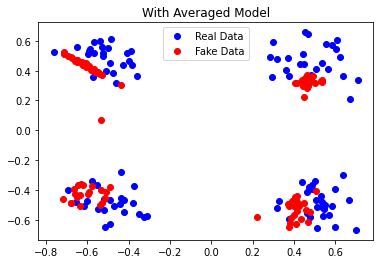


 Epoch : 3000


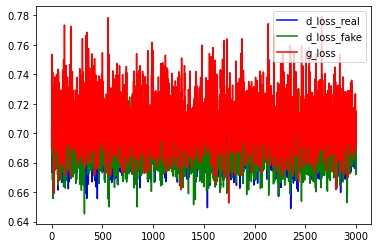

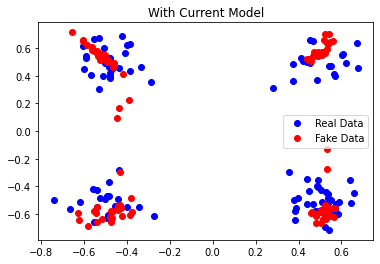

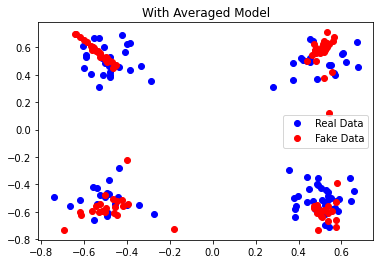


 Epoch : 3100


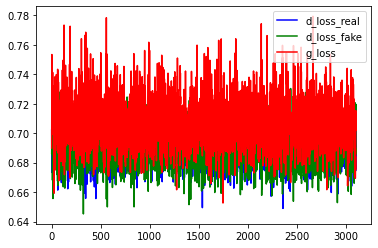

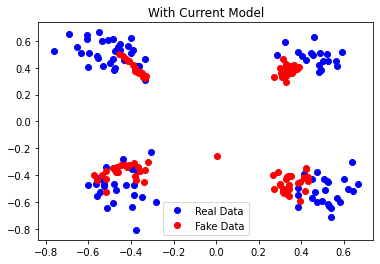

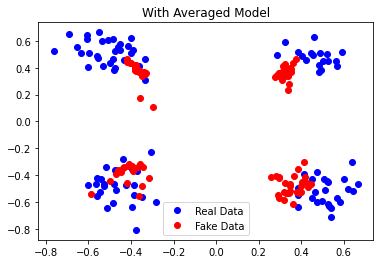


 Epoch : 3200


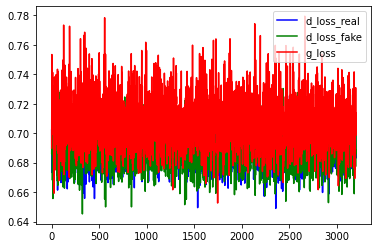

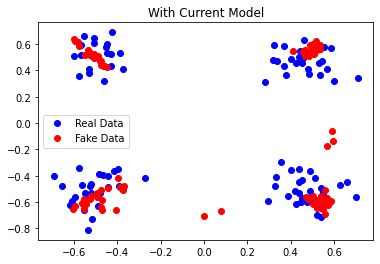

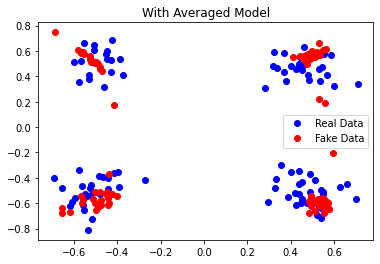


 Epoch : 3300


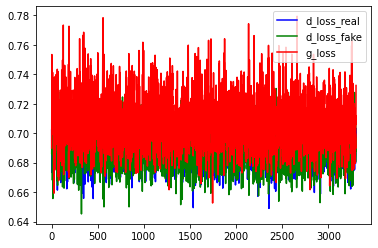

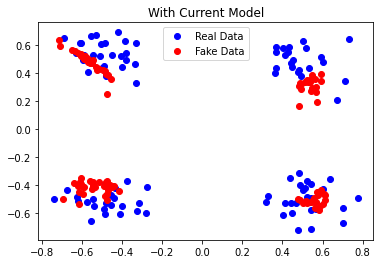

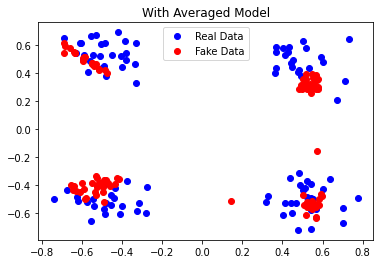


 Epoch : 3400


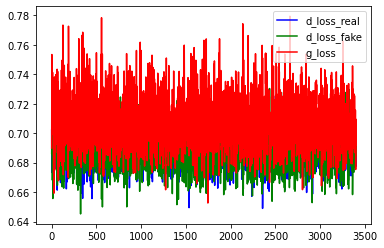

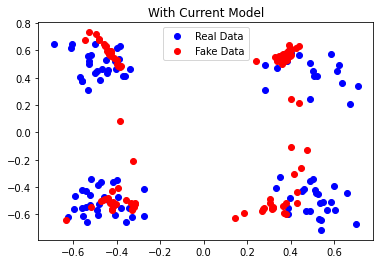

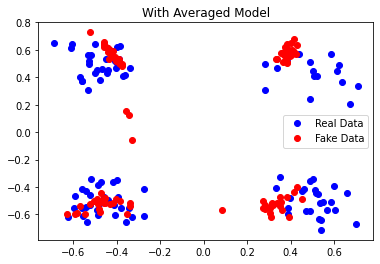


 Epoch : 3500


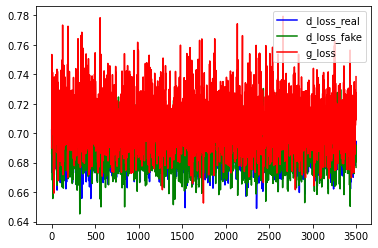

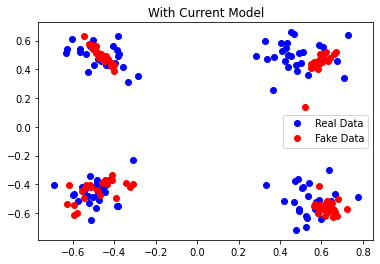

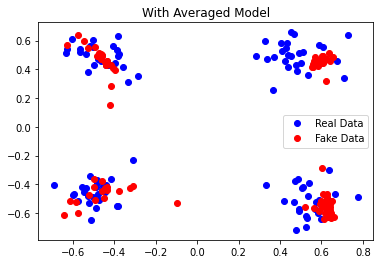


 Epoch : 3600


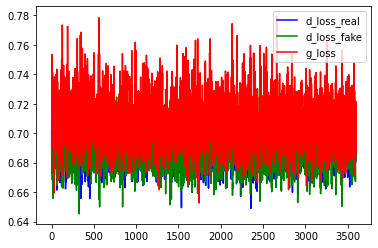

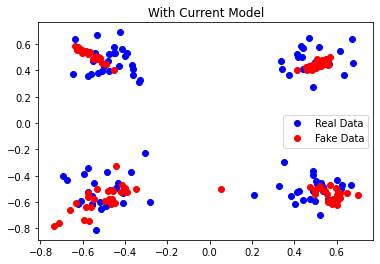

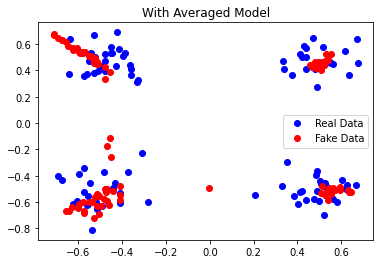


 Epoch : 3700


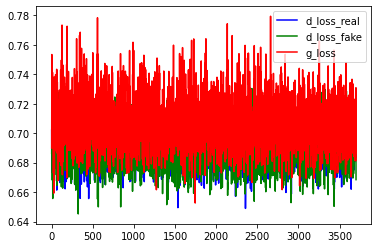

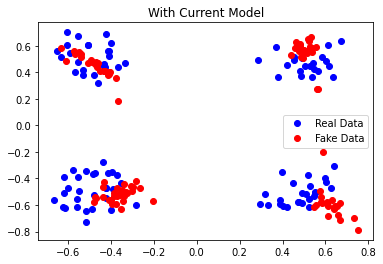

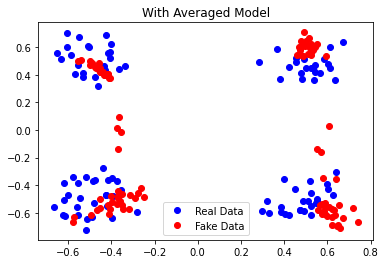


 Epoch : 3800


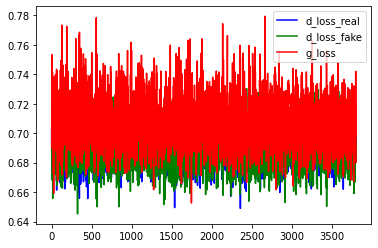

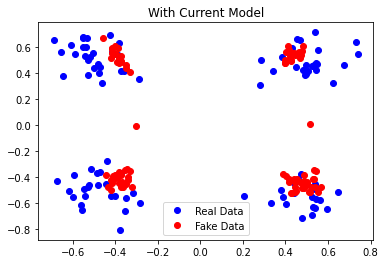

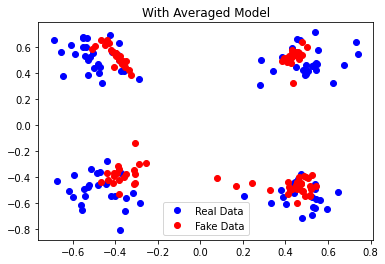


 Epoch : 3900


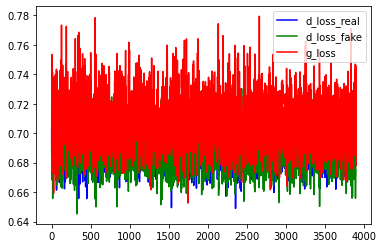

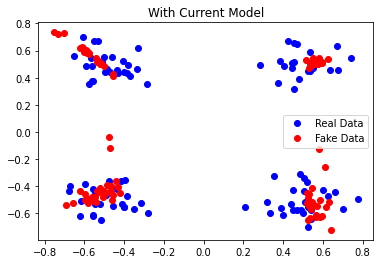

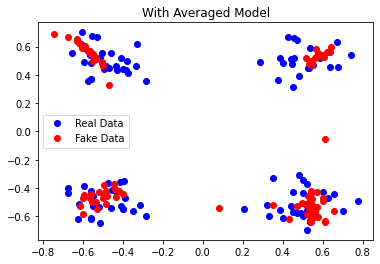


 Epoch : 4000


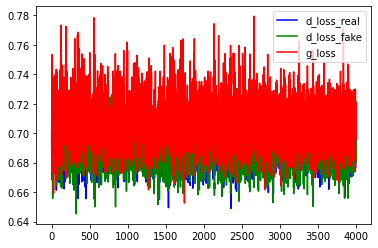

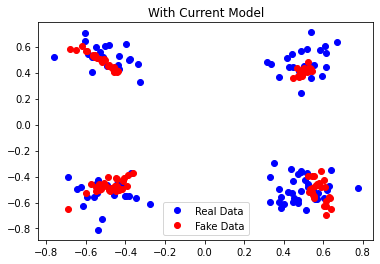

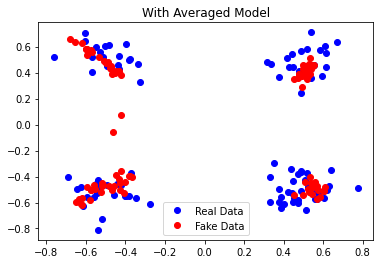


 Epoch : 4100


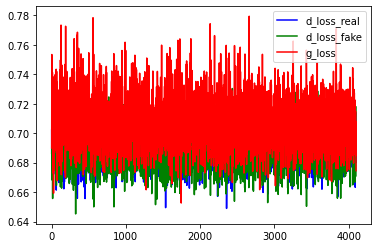

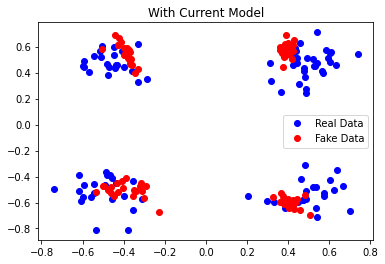

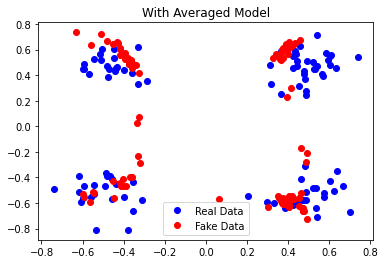


 Epoch : 4200


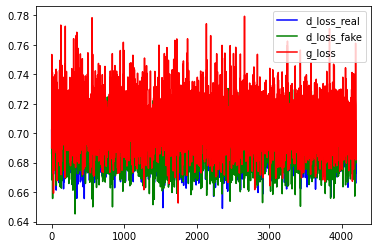

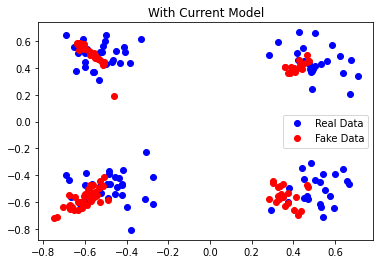

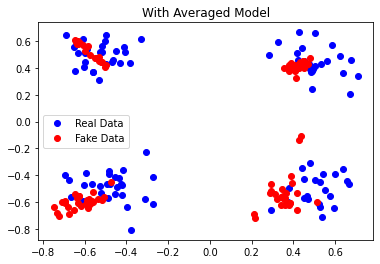


 Epoch : 4300


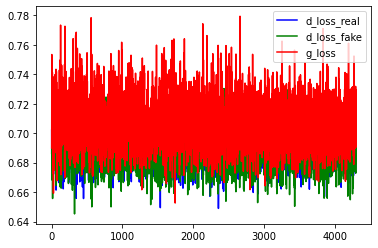

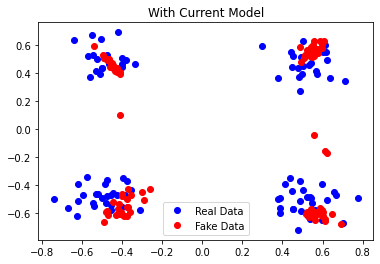

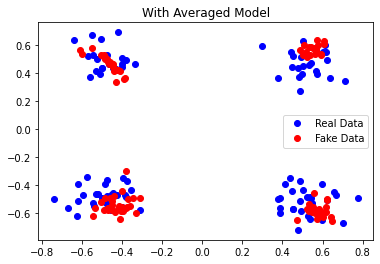


 Epoch : 4400


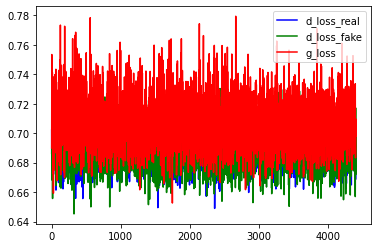

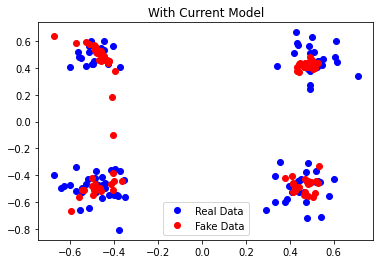

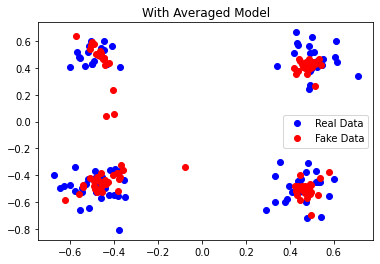


 Epoch : 4500


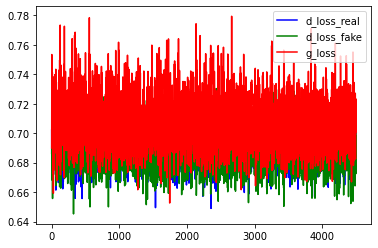

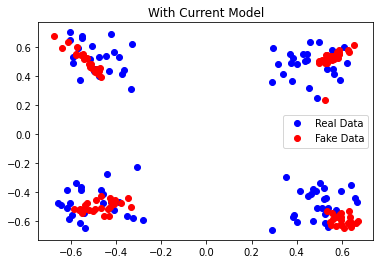

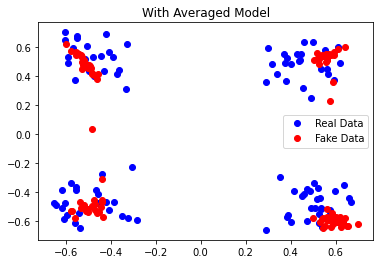


 Epoch : 4600


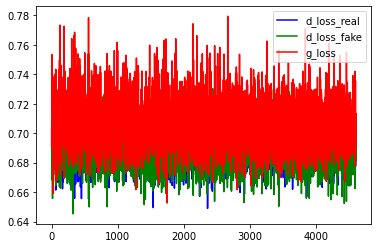

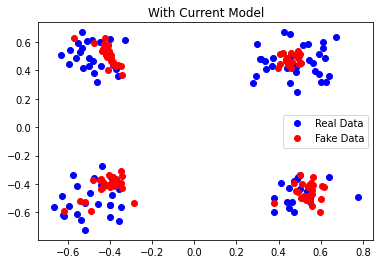

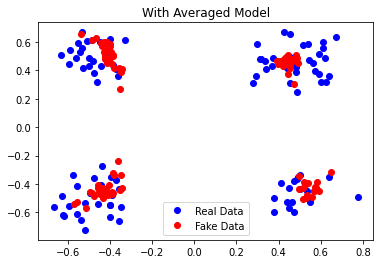


 Epoch : 4700


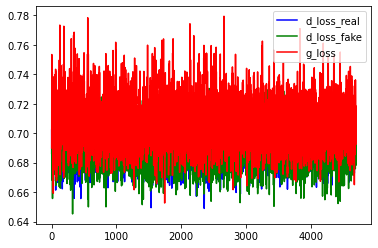

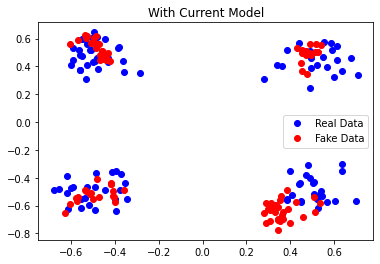

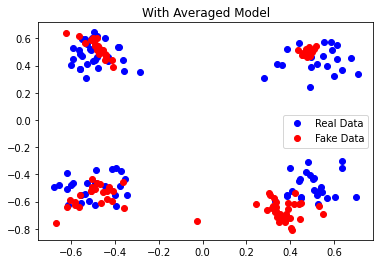


 Epoch : 4800


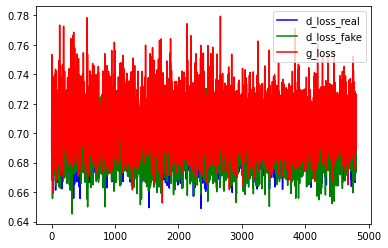

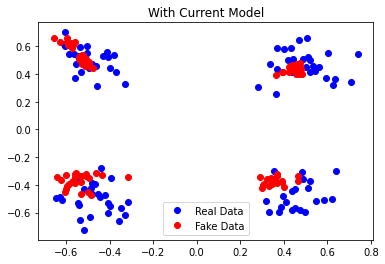

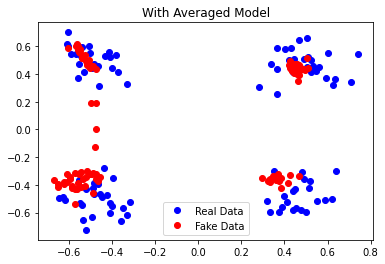


 Epoch : 4900


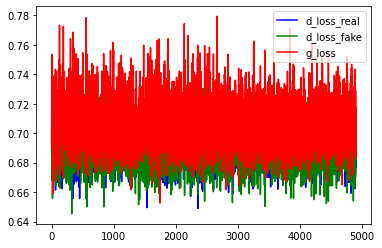

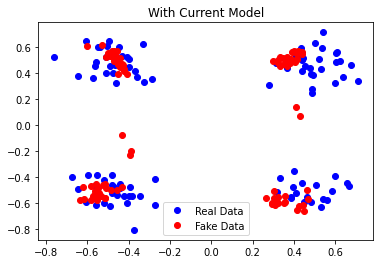

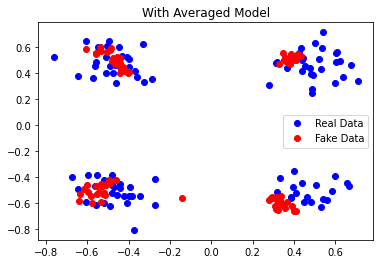


 Epoch : 5000


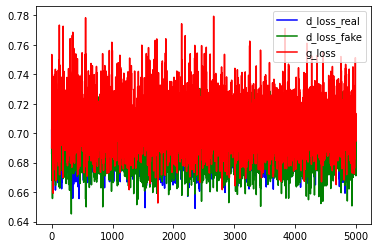

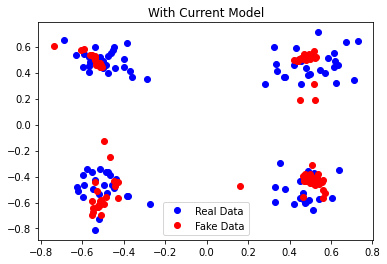

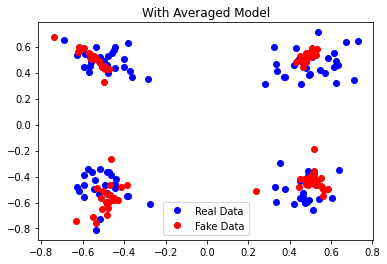


 Epoch : 5100


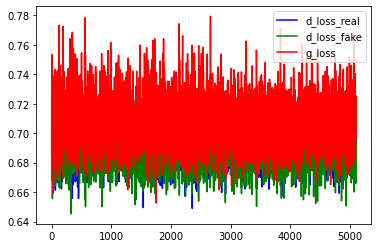

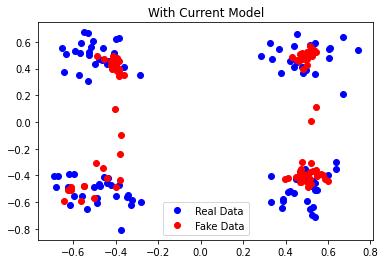

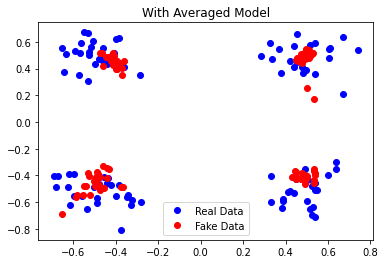


 Epoch : 5200


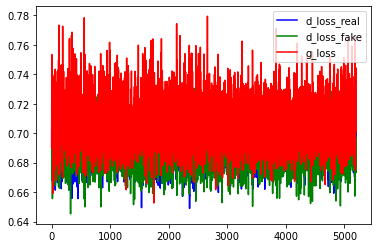

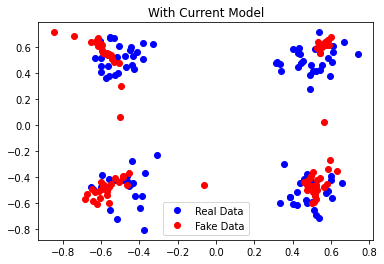

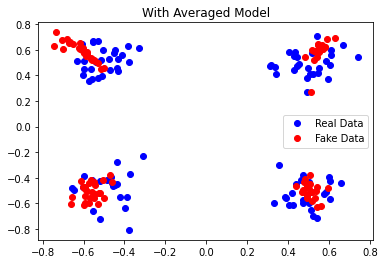


 Epoch : 5300


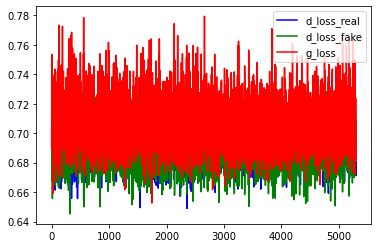

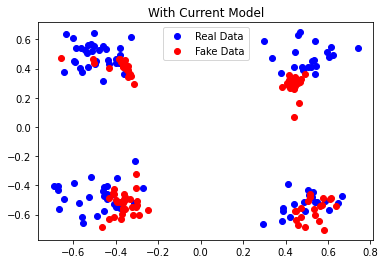

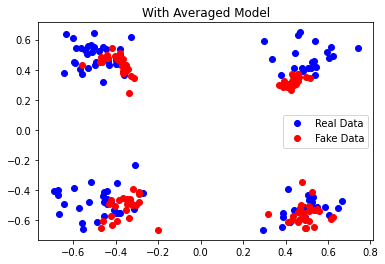


 Epoch : 5400


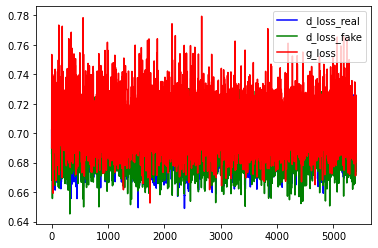

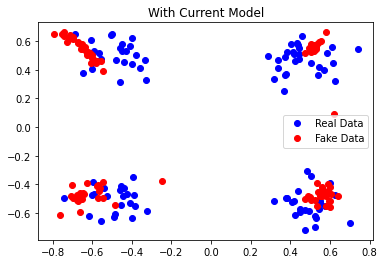

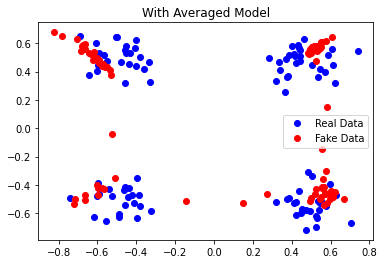


 Epoch : 5500


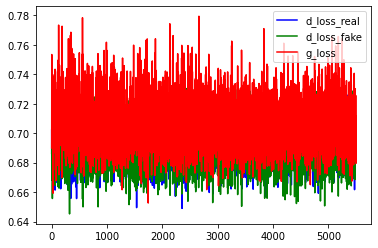

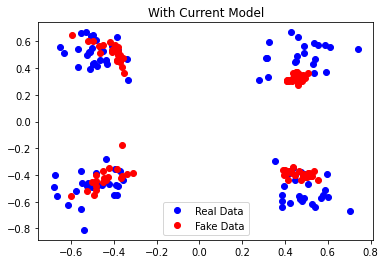

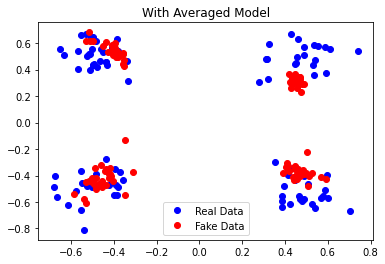


 Epoch : 5600


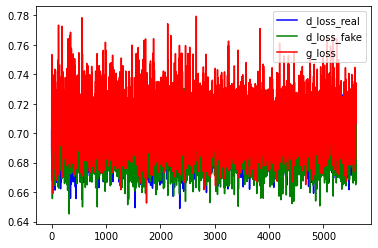

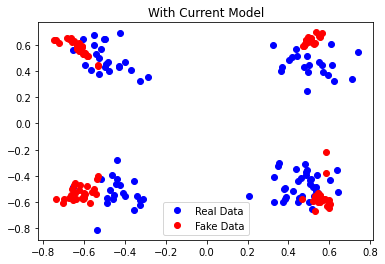

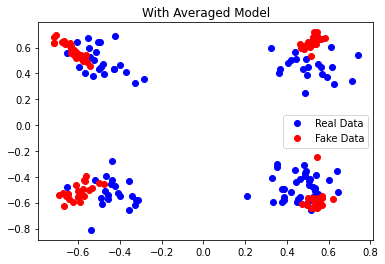


 Epoch : 5700


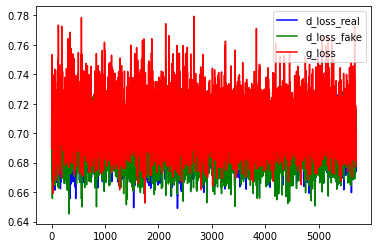

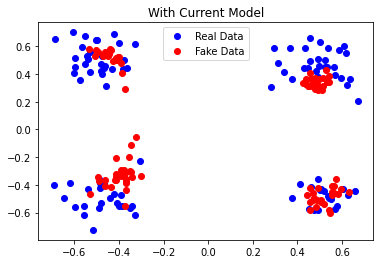

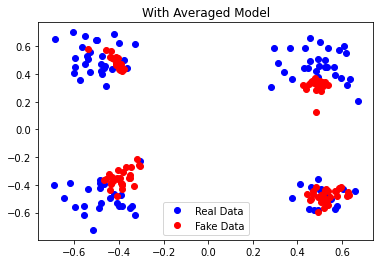


 Epoch : 5800


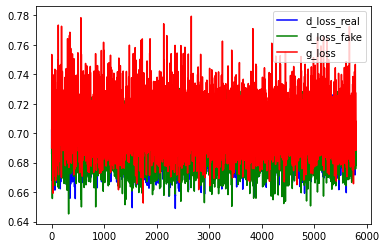

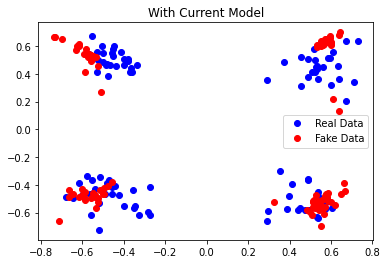

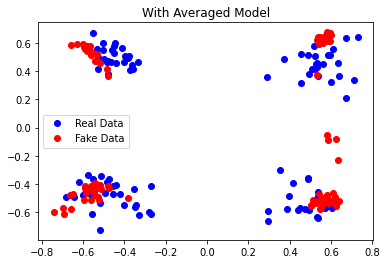


 Epoch : 5900


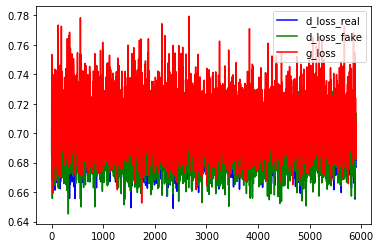

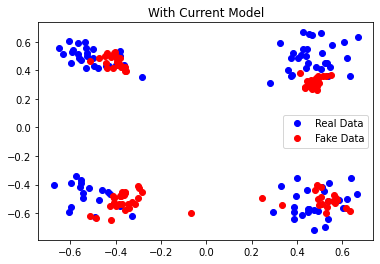

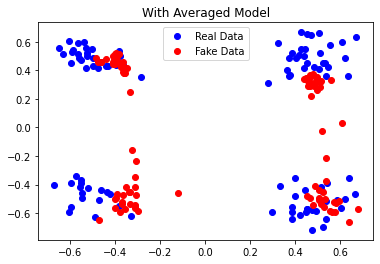


 Epoch : 6000


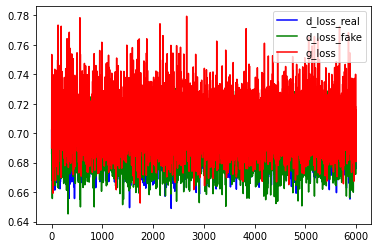

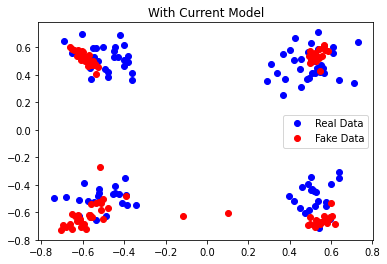

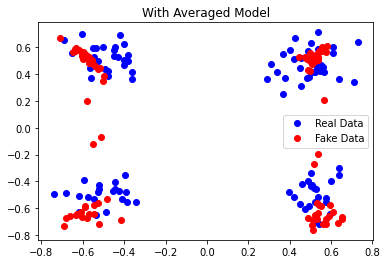


 Epoch : 6100


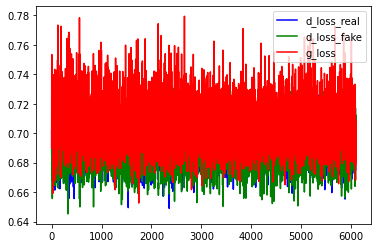

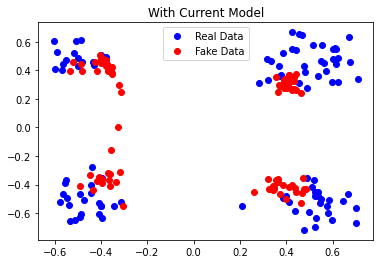

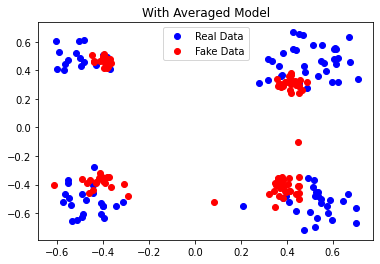


 Epoch : 6200


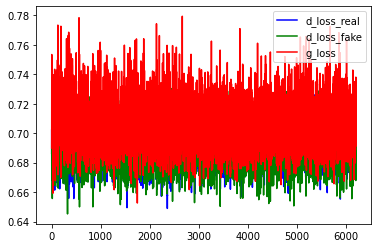

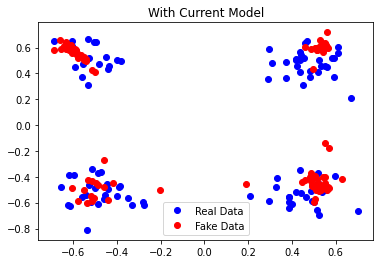

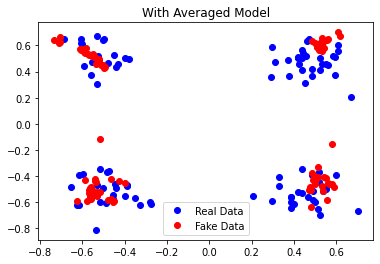


 Epoch : 6300


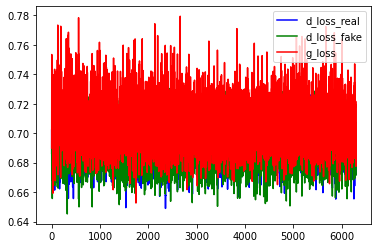

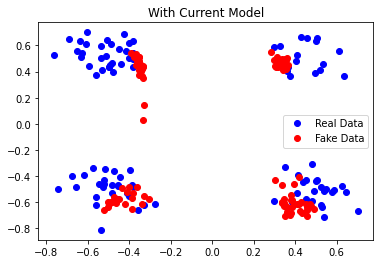

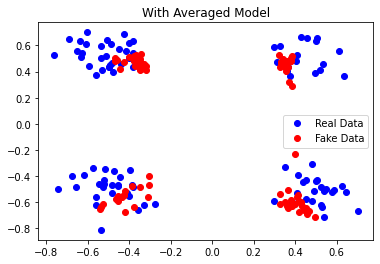


 Epoch : 6400


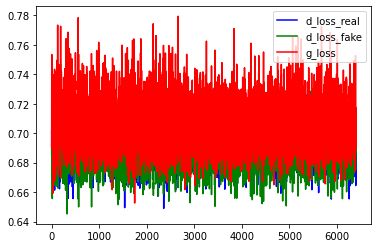

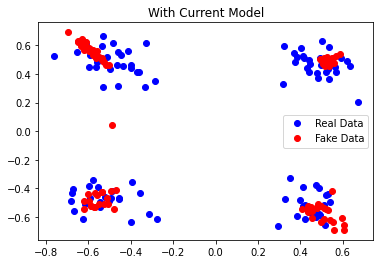

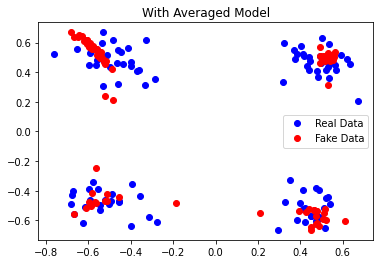


 Epoch : 6500


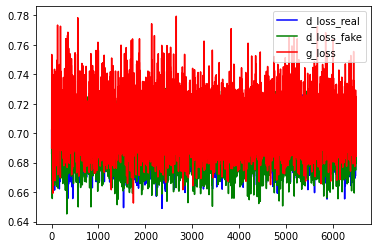

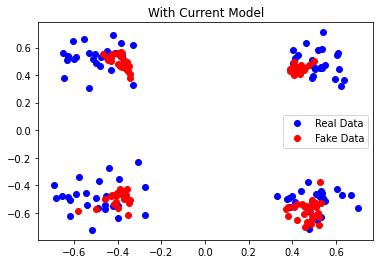

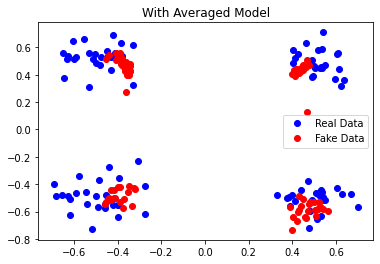


 Epoch : 6600


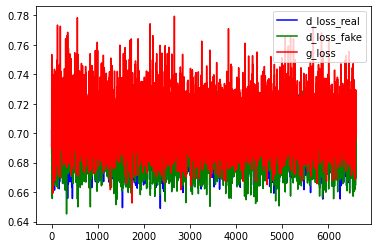

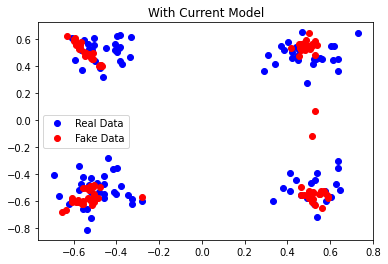

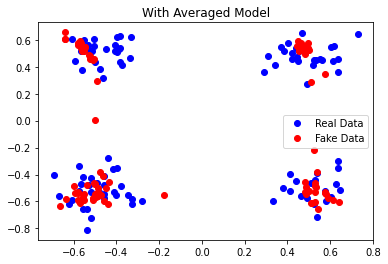


 Epoch : 6700


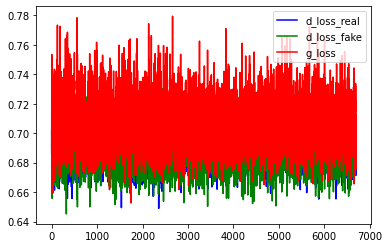

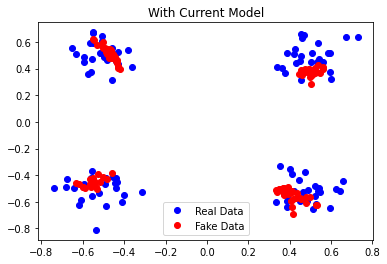

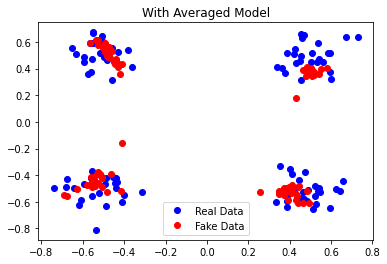


 Epoch : 6800


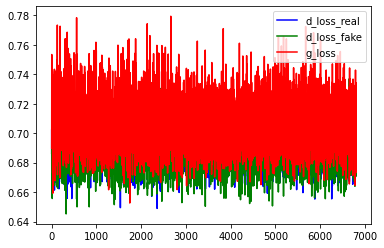

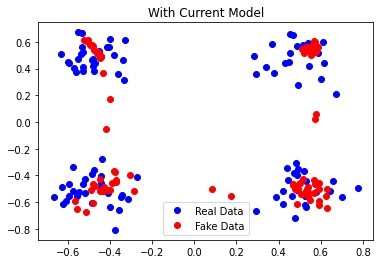

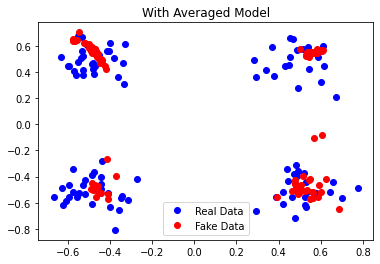


 Epoch : 6900


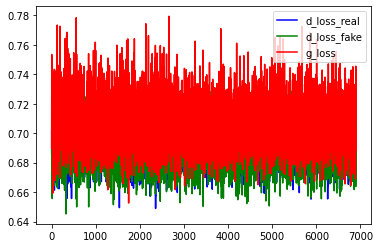

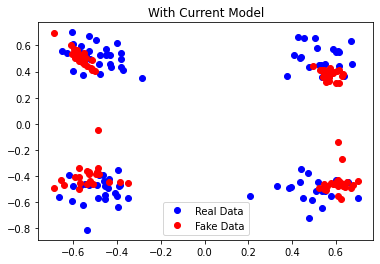

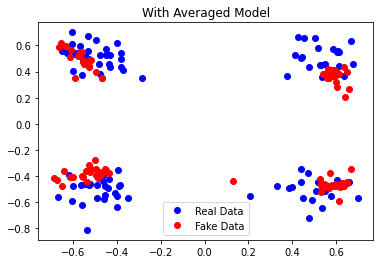


 Epoch : 7000


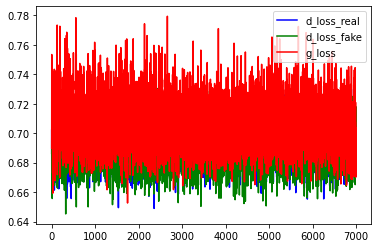

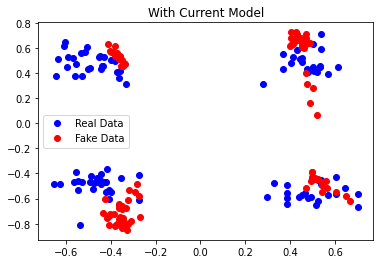

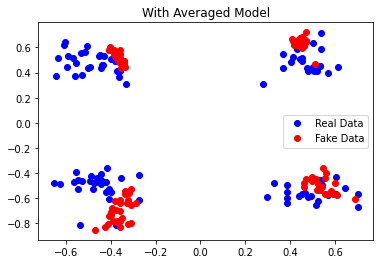


 Epoch : 7100


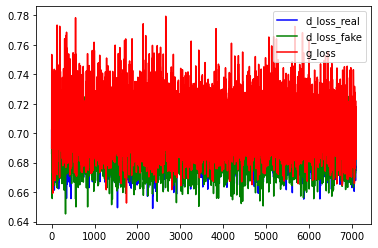

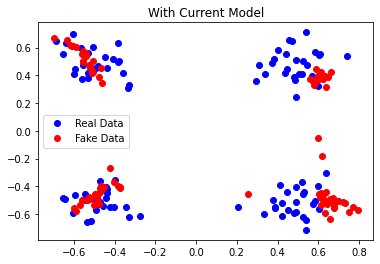

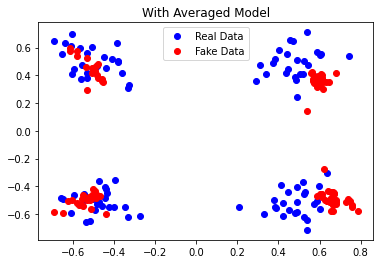


 Epoch : 7200


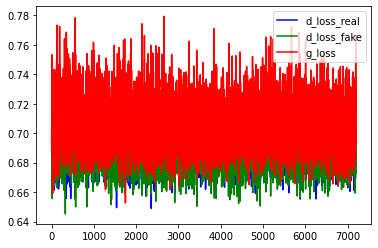

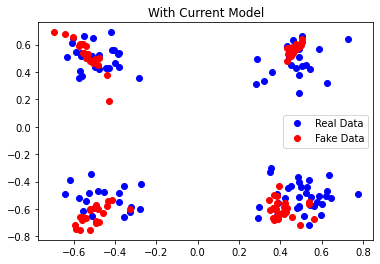

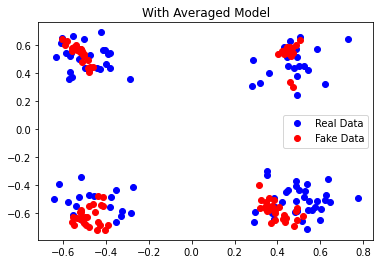


 Epoch : 7300


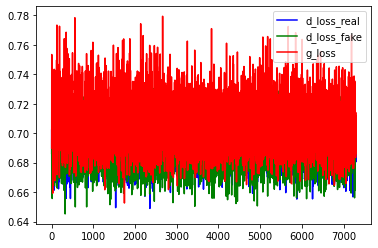

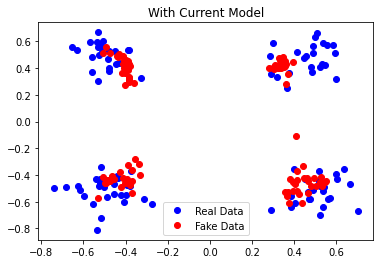

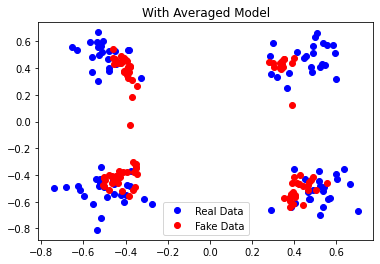


 Epoch : 7400


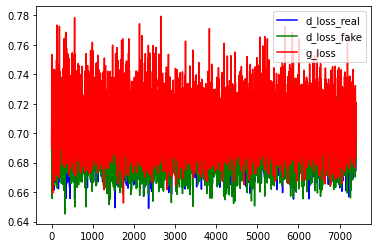

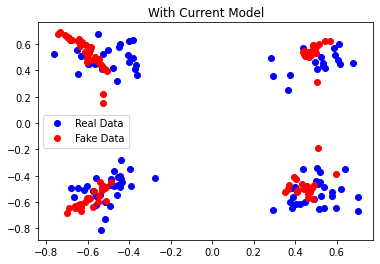

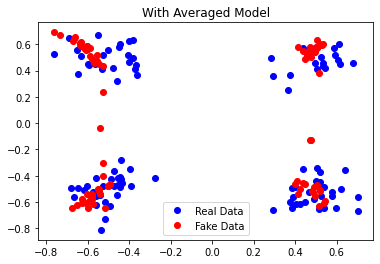


 Epoch : 7500


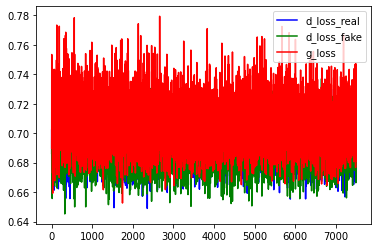

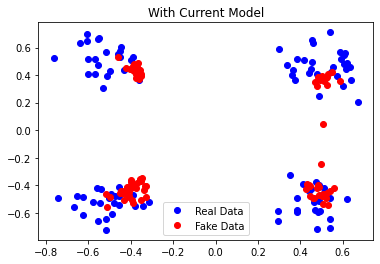

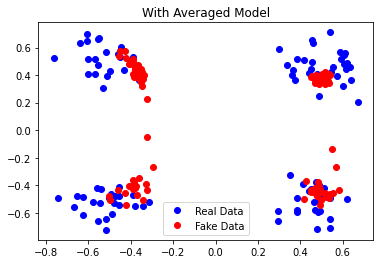


 Epoch : 7600


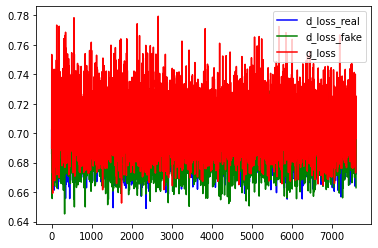

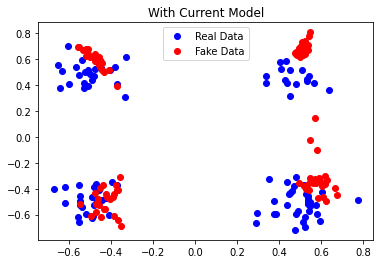

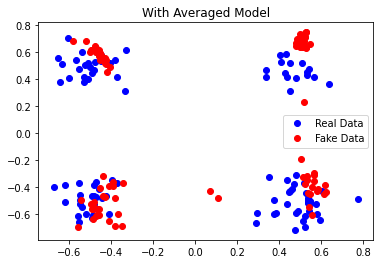


 Epoch : 7700


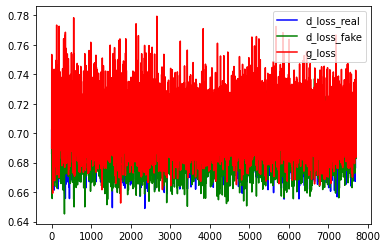

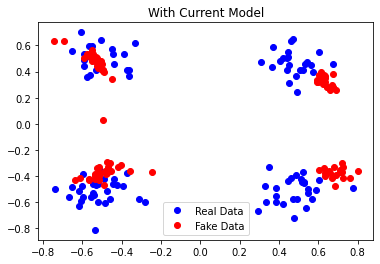

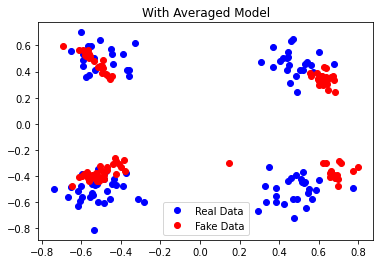


 Epoch : 7800


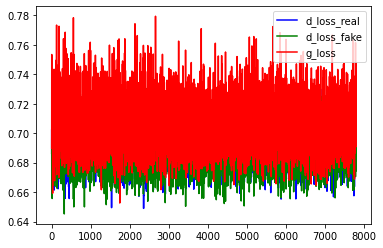

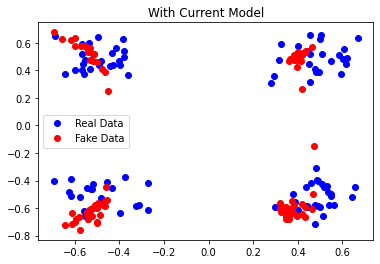

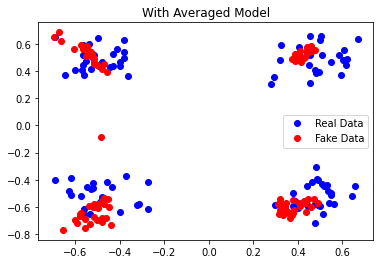


 Epoch : 7900


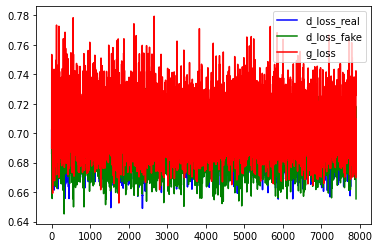

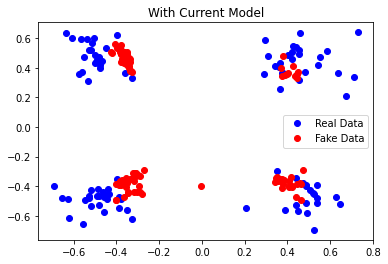

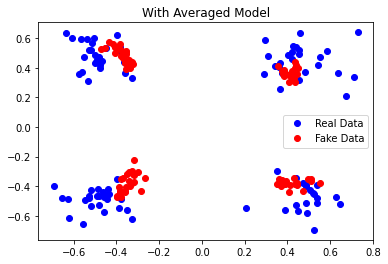


 Epoch : 8000


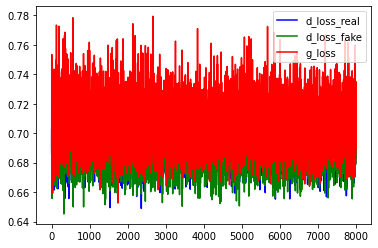

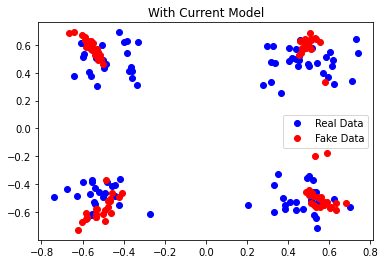

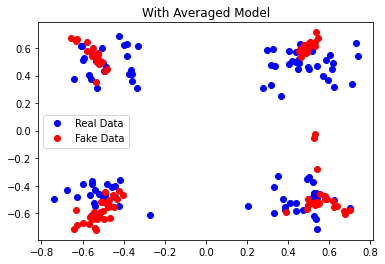


 Epoch : 8100


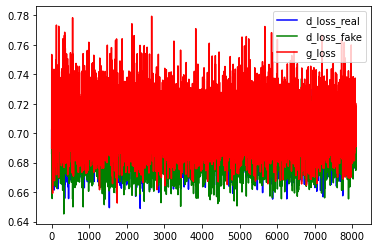

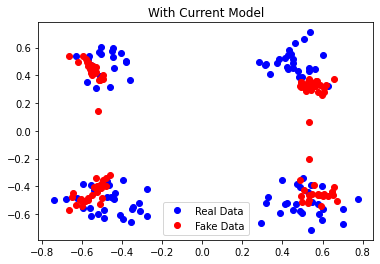

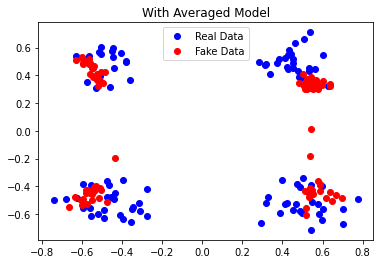


 Epoch : 8200


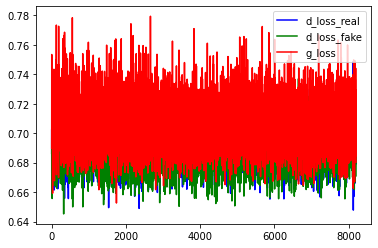

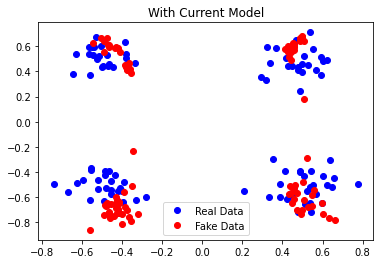

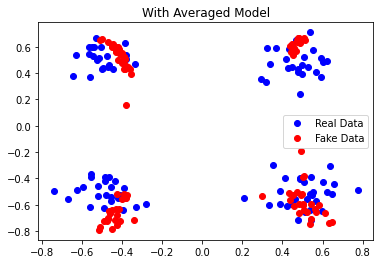


 Epoch : 8300


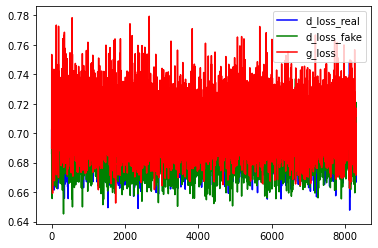

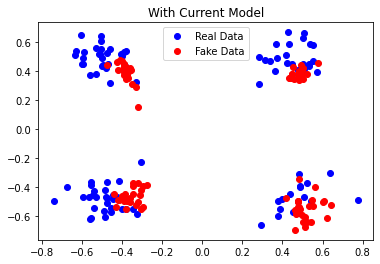

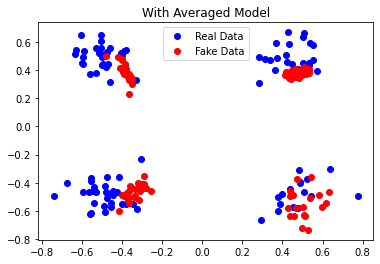


 Epoch : 8400


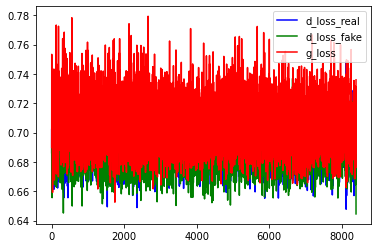

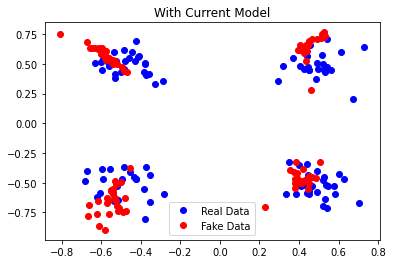

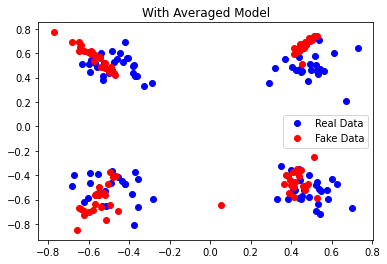


 Epoch : 8500


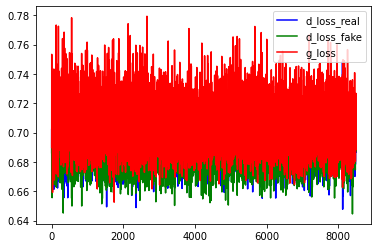

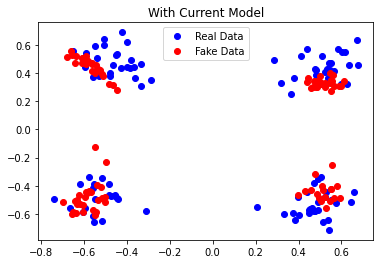

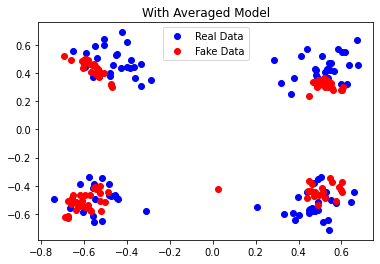


 Epoch : 8600


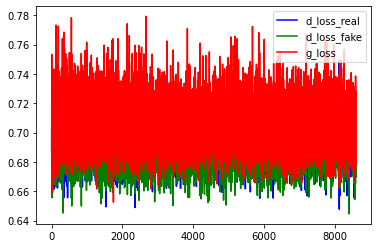

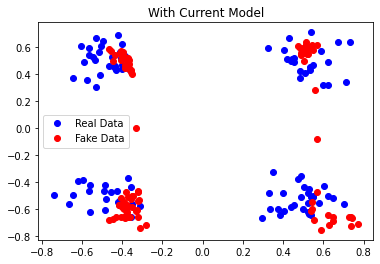

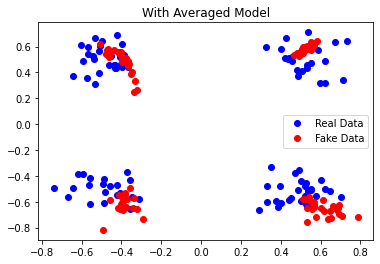


 Epoch : 8700


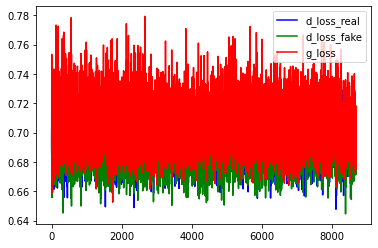

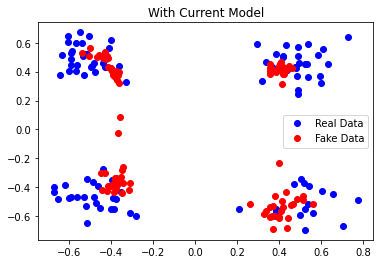

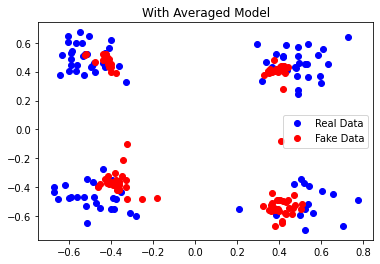


 Epoch : 8800


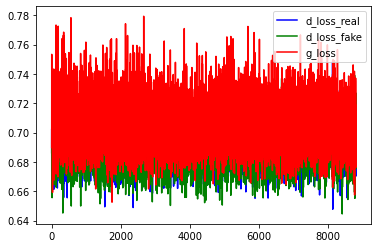

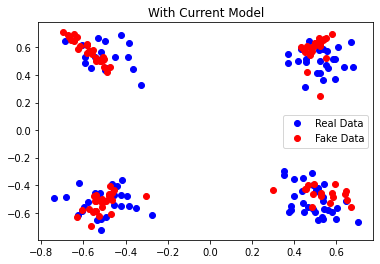

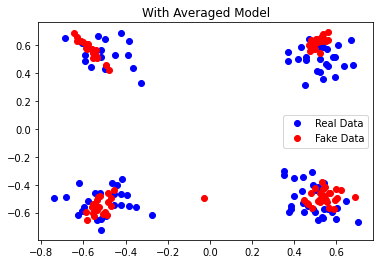


 Epoch : 8900


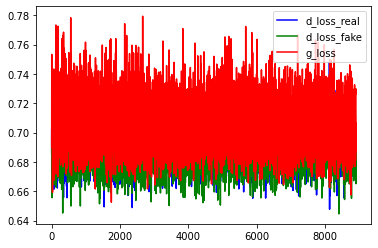

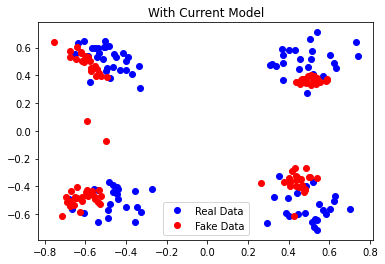

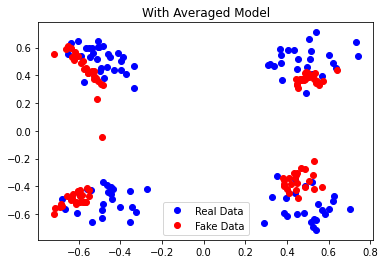


 Epoch : 9000


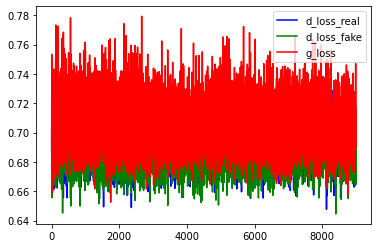

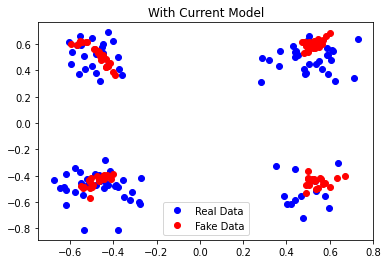

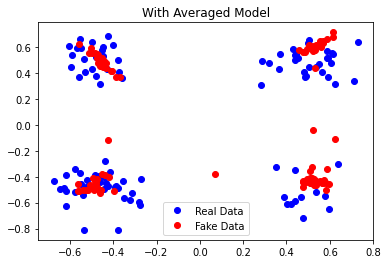


 Epoch : 9100


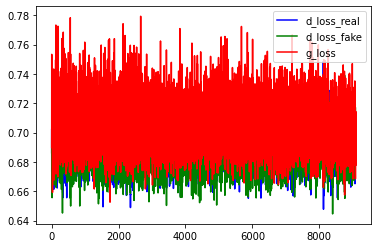

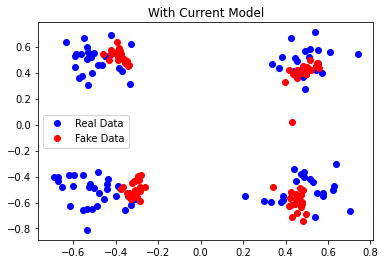

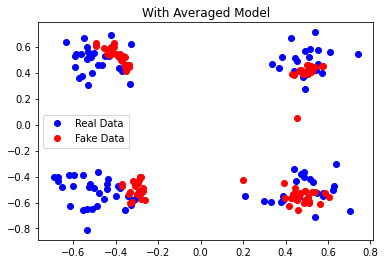


 Epoch : 9200


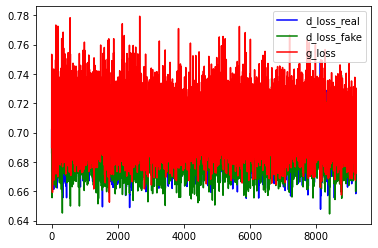

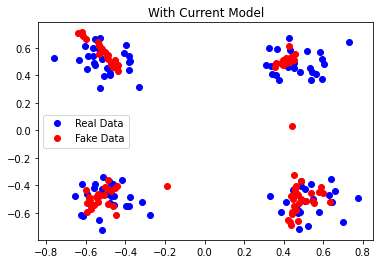

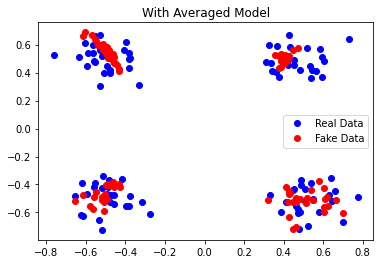


 Epoch : 9300


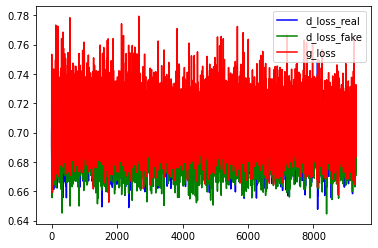

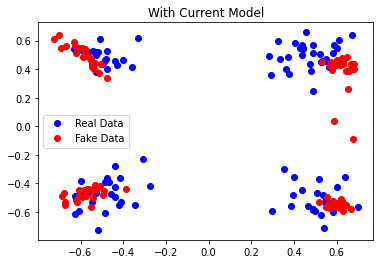

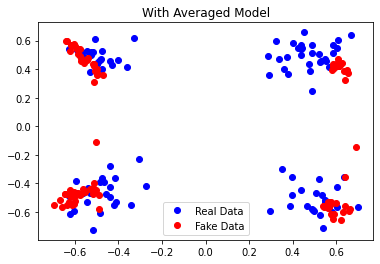


 Epoch : 9400


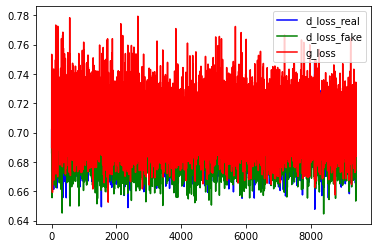

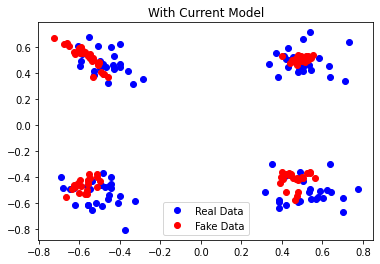

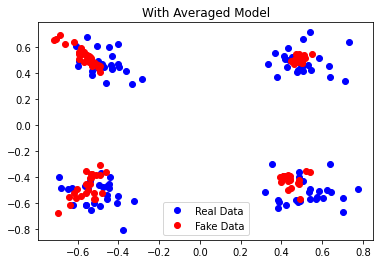


 Epoch : 9500


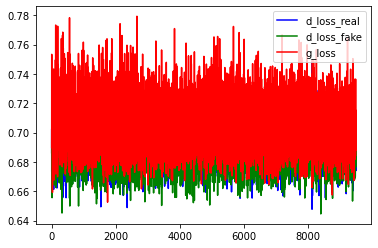

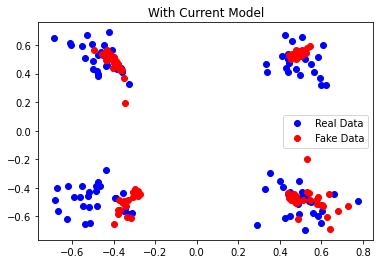

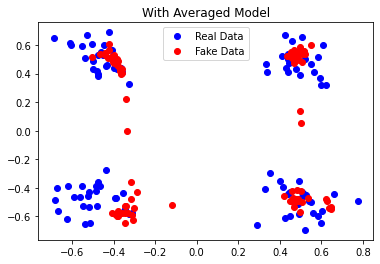


 Epoch : 9600


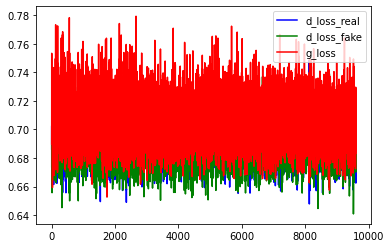

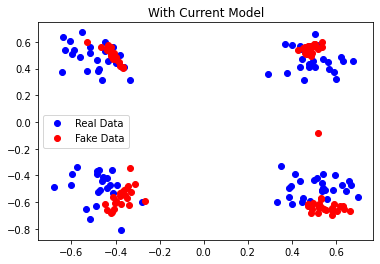

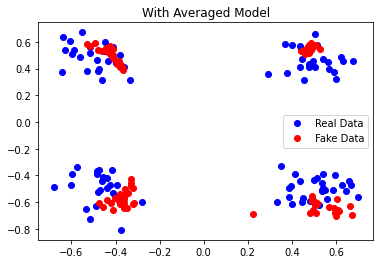


 Epoch : 9700


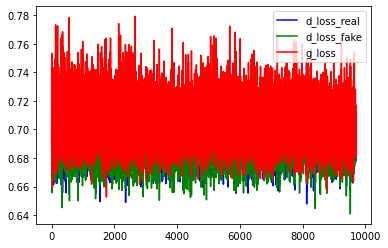

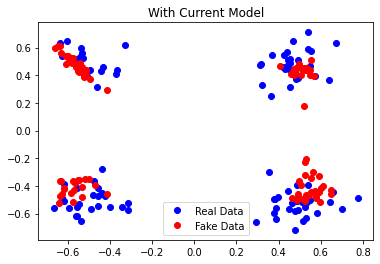

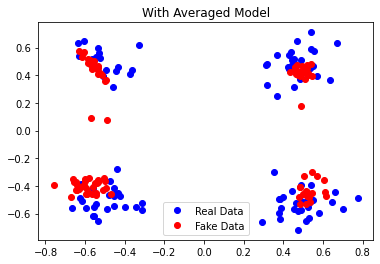


 Epoch : 9800


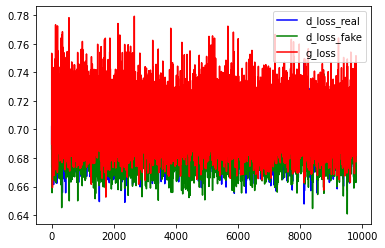

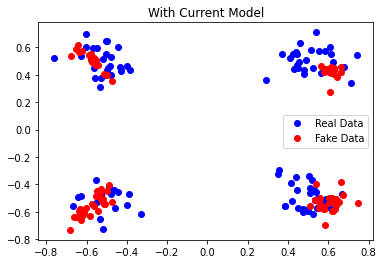

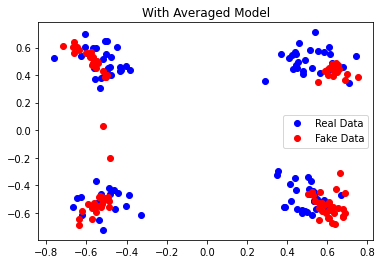


 Epoch : 9900


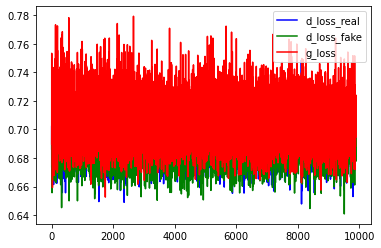

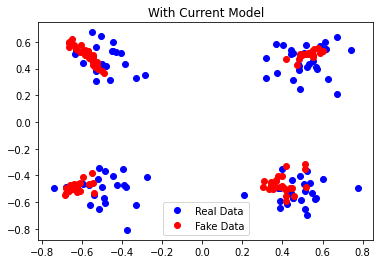

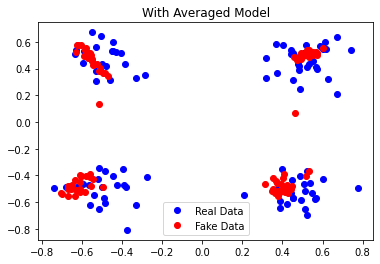

In [158]:
ds = MixGaussian2D(4, [[0.5,-0.5], [0.5,0.5], [-0.5,-0.5], [-0.5,0.5]], [100, 100, 100, 100], cov_factor = 0.01)
train_gan(ds, D, G, hyperparam, opt)

TODO:

1.   Larger Dataset
2. More Modes
3. Other models 
4. EWMA
5. Find out some task which is hard to do with vanilla and then try this (maybe the toy datasets in your arxiv paper might be useful) (also check whether you converge faster)
6. A way to quantify oscillations
